In [35]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import os
import gc
import glob
import torch
import math
import utils
from scipy.special import erf
from sklearn.calibration import calibration_curve
from sklearn.metrics import (auc, brier_score_loss, confusion_matrix,
                             mean_absolute_error, mean_squared_error,
                             precision_recall_curve, r2_score, roc_curve,
							 precision_score, recall_score, f1_score,
                             mutual_info_score)
from sklearn.feature_selection import mutual_info_regression, r_regression
from scipy.stats import entropy
import utils

In [36]:
model_type = 'swmag'
shap_dir = 'outputs/shap_values'
scaler_dir = 'outputs/scalers'
results_dir = 'outputs/rsd'
dbht_results_dir = 'outputs/dbht_max'
VERSION = 'swmag_v6-1'
shap_files = glob.glob(f'{shap_dir}/*{VERSION}*.pkl')
scaler_files = glob.glob(f'{scaler_dir}/*{VERSION}.pkl')
results_files = glob.glob(f'{scaler_dir}/*{VERSION}.feather')
with open('cluster_dict.pkl', 'rb') as f:
	cluster_dict = pickle.load(f)

list_of_oversampled_regions = ['GRL-1', 'GRL-2', 'SVLB', 'JPN-0']

In [37]:
results = {}
for cluster in cluster_dict.values():
	for key, region in cluster['regions'].items():
		results[key] = {}
		results[key]['mean_lat'] = utils.getting_mean_lat(region['stations'])
		results[key]['mlt_station'] = region['mlt_station']
		if key in list_of_oversampled_regions:
			results[key]['swmag_results'] = pd.read_feather(f'{results_dir}/non_twins_modeling_region_{key}_version_swmag_v6-oversampling.feather')
			results[key]['twins_results'] = pd.read_feather(f'{results_dir}/twins_modeling_region_{key}_version_twins_v_maxpooling_oversampling.feather')
			results[key]['alt_results'] = pd.read_feather(f'{results_dir}/twins_modeling_region_{key}_version_twins_alt_method_v_maxpooling_oversampling.feather')
			results[key]['alt_v2'] = pd.read_feather(f'{results_dir}/twins_modeling_region_{key}_version_twins_alt_method_v2_maxpooling_oversampling.feather')
			results[key]['dbht'] = pd.read_feather(f'{dbht_results_dir}/twins_modeling_region_{key}_version_twins_v_dbht_maxpooling_oversampling.feather')
			results[key]['alt_v3'] = pd.read_feather(f'{results_dir}/twins_modeling_region_{key}_version_twins_alt_method_v3_maxpooling.feather')

		else:
			results[key]['swmag_results'] = pd.read_feather(f'{results_dir}/non_twins_modeling_region_{key}_version_swmag_v6-1.feather')
			results[key]['twins_results'] = pd.read_feather(f'{results_dir}/twins_modeling_region_{key}_version_twins_v_maxpooling.feather')
			results[key]['dbht'] = pd.read_feather(f'{dbht_results_dir}/twins_modeling_region_{key}_version_twins_v_dbht_maxpooling.feather')
			results[key]['alt_v3'] = pd.read_feather(f'{results_dir}/twins_modeling_region_{key}_version_twins_alt_method_v3_maxpooling.feather')
			if key == 'JPN-1':
				continue
			results[key]['alt_results'] = pd.read_feather(f'{results_dir}/twins_modeling_region_{key}_version_twins_alt_method_v_maxpooling.feather')
			results[key]['alt_v2'] = pd.read_feather(f'{results_dir}/twins_modeling_region_{key}_version_twins_alt_method_v2_maxpooling.feather')
			

results['JPN-1']['alt_results'] = pd.read_feather(f'{results_dir}/twins_modeling_region_JPN-1_version_twins_alt_method_v_maxpooling_oversampling.feather')
results['JPN-1']['alt_v2'] = pd.read_feather(f'{results_dir}/twins_modeling_region_JPN-1_version_twins_alt_method_v2_maxpooling_oversampling.feather')
results['GRL-0']['dbht'] = pd.read_feather(f'{dbht_results_dir}/twins_modeling_region_GRL-0_version_twins_v_dbht_maxpooling_oversampling.feather')

Loading station NEW....
Loading station T19....
Loading station C10....
Loading station LET....
Loading station T03....
Loading station T43....
Loading station LET....
Loading station T03....
Loading station T43....
Loading station RED....
Loading station C06....
Loading station T43....
Loading station RED....
Loading station C06....
Loading station MEA....
Loading station T36....
Loading station GHB....
Loading station SKT....
Loading station STF....
Loading station ATU....
Loading station SKT....
Loading station STF....
Loading station ATU....
Loading station GDH....
Loading station STF....
Loading station ATU....
Loading station GDH....
Loading station UMQ....
Loading station GHB....
Loading station FHB....
Loading station NAQ....
Loading station RVK....
Loading station LYC....
Loading station DON....
Loading station JCK....
Loading station HAN....
Loading station MEK....
Loading station OUJ....
Loading station NUR....
Loading station MAS....
Loading station NOR....
Loading station 

       predicted_mean  predicted_std  actual               dates
15957        0.000017       0.000036     0.0 2016-01-02 13:15:00
15958        0.000018       0.000039     0.0 2016-01-02 13:16:00
15959        0.000019       0.000039     0.0 2016-01-02 13:17:00
15960        0.000028       0.000052     0.0 2016-01-02 13:18:00
15961        0.000022       0.000043     0.0 2016-01-02 13:19:00


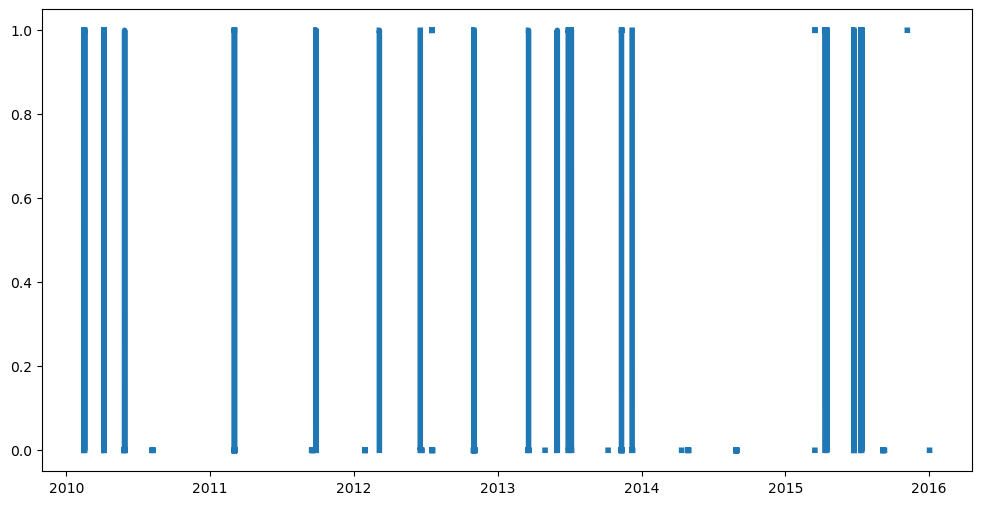

In [38]:
date_range = pd.date_range('2009-07-20', '2017-12-31', freq='min')
print(results['FSC-4']['alt_v3'].tail())

temp_df = results['FSC-4']['alt_v3'].set_index('dates', drop=True, inplace=False)
plotting_df = pd.DataFrame(index=date_range)
plotting_df = plotting_df.join(temp_df, how='left')

fig, axes = plt.subplots(1, 1, figsize=(12, 6))
axes.plot(plotting_df.index, plotting_df['actual'], linewidth=4)

# temp_df = results['FSC-4']['twins_results'].set_index('dates', drop=True, inplace=False)
# plotting_df = pd.DataFrame(index=date_range)
# plotting_df = plotting_df.join(temp_df, how='left')
# axes.plot(plotting_df.index, plotting_df['actual'], linewidth=4)
plt.show()

In [39]:
swmag_auc, maxpool_auc, alt_auc, alt_v2_auc, alt_v3_auc, dbht_auc, swmag_roc, maxpool_roc, alt_roc, alt_v2_roc, alt_v3_roc, dbht_roc, mean_lat = [], [], [], [], [], [], [], [], [], [], [], [], []
for key in results.keys():
	print(key)
	roc = roc_curve(y_true=results[key]['swmag_results']['actual'], y_score=results[key]['swmag_results']['predicted_mean'])
	swmag_roc.append(auc(roc[0], roc[1]))
	roc = roc_curve(y_true=results[key]['twins_results']['actual'], y_score=results[key]['twins_results']['predicted_mean'])
	maxpool_roc.append(auc(roc[0], roc[1]))
	roc = roc_curve(y_true=results[key]['alt_results']['actual'], y_score=results[key]['alt_results']['predicted_mean'])
	alt_roc.append(auc(roc[0], roc[1]))
	roc = roc_curve(y_true=results[key]['alt_v2']['actual'], y_score=results[key]['alt_v2']['predicted_mean'])
	alt_v2_roc.append(auc(roc[0], roc[1]))
	roc = roc_curve(y_true=results[key]['alt_v3']['actual'], y_score=results[key]['alt_v3']['predicted_mean'])
	alt_v3_roc.append(auc(roc[0], roc[1]))
	roc = roc_curve(y_true=results[key]['dbht']['actual'], y_score=results[key]['dbht']['predicted_mean'])
	dbht_roc.append(auc(roc[0], roc[1]))
	prec, rec, __ = precision_recall_curve(y_true=results[key]['swmag_results']['actual'], probas_pred=results[key]['swmag_results']['predicted_mean'])
	swmag_auc.append(auc(rec, prec))
	prec, rec, __ = precision_recall_curve(y_true=results[key]['twins_results']['actual'], probas_pred=results[key]['twins_results']['predicted_mean'])
	maxpool_auc.append(auc(rec, prec))
	prec, rec, __ = precision_recall_curve(y_true=results[key]['alt_results']['actual'], probas_pred=results[key]['alt_results']['predicted_mean'])
	alt_auc.append(auc(rec, prec))
	prec, rec, __ = precision_recall_curve(y_true=results[key]['alt_v2']['actual'], probas_pred=results[key]['alt_v2']['predicted_mean'])
	alt_v2_auc.append(auc(rec, prec))
	prec, rec, __ = precision_recall_curve(y_true=results[key]['alt_v3']['actual'], probas_pred=results[key]['alt_v3']['predicted_mean'])
	alt_v3_auc.append(auc(rec, prec))
	prec, rec, __ = precision_recall_curve(y_true=results[key]['dbht']['actual'], probas_pred=results[key]['dbht']['predicted_mean'])
	dbht_auc.append(auc(rec, prec))
	mean_lat.append(results[key]['mean_lat'])

CAN-0
CAN-1
CAN-2
GRL-0
GRL-1
GRL-2
GRL-3
FSC-0
FSC-1
FSC-2
FSC-3
FSC-4
FSC-5
FSC-6
CEU-0
CEU-1
CEU-2
CEU-3
SVLB
JPN-0
JPN-1
ALSK
HUD-0
HUD-1


In [40]:
swmag_plot_df = pd.DataFrame({'mean_lat':mean_lat, 'swmag_auc':swmag_auc, 'swmag_roc':swmag_roc})
maxpool_plot_df = pd.DataFrame({'mean_lat':mean_lat, 'twins_auc':maxpool_auc, 'twins_roc':maxpool_roc})
alt_plot_df = pd.DataFrame({'mean_lat':mean_lat, 'alt_auc':alt_auc, 'alt_roc':alt_roc})
alt_v2_plot_df = pd.DataFrame({'mean_lat':mean_lat, 'alt_v2_auc':alt_v2_auc, 'alt_v2_roc':alt_v2_roc})
alt_v3_plot_df = pd.DataFrame({'mean_lat':mean_lat, 'alt_v3_auc':alt_v3_auc, 'alt_v3_roc':alt_v3_roc})
dbht_plot_df = pd.DataFrame({'mean_lat':mean_lat, 'dbht_auc':dbht_auc, 'dbht_roc':dbht_roc})

swmag_plot_df.sort_values(by='mean_lat', inplace=True)
maxpool_plot_df.sort_values(by='mean_lat', inplace=True)
alt_plot_df.sort_values(by='mean_lat', inplace=True)
alt_v2_plot_df.sort_values(by='mean_lat', inplace=True)
alt_v3_plot_df.sort_values(by='mean_lat', inplace=True)
dbht_plot_df.sort_values(by='mean_lat', inplace=True)

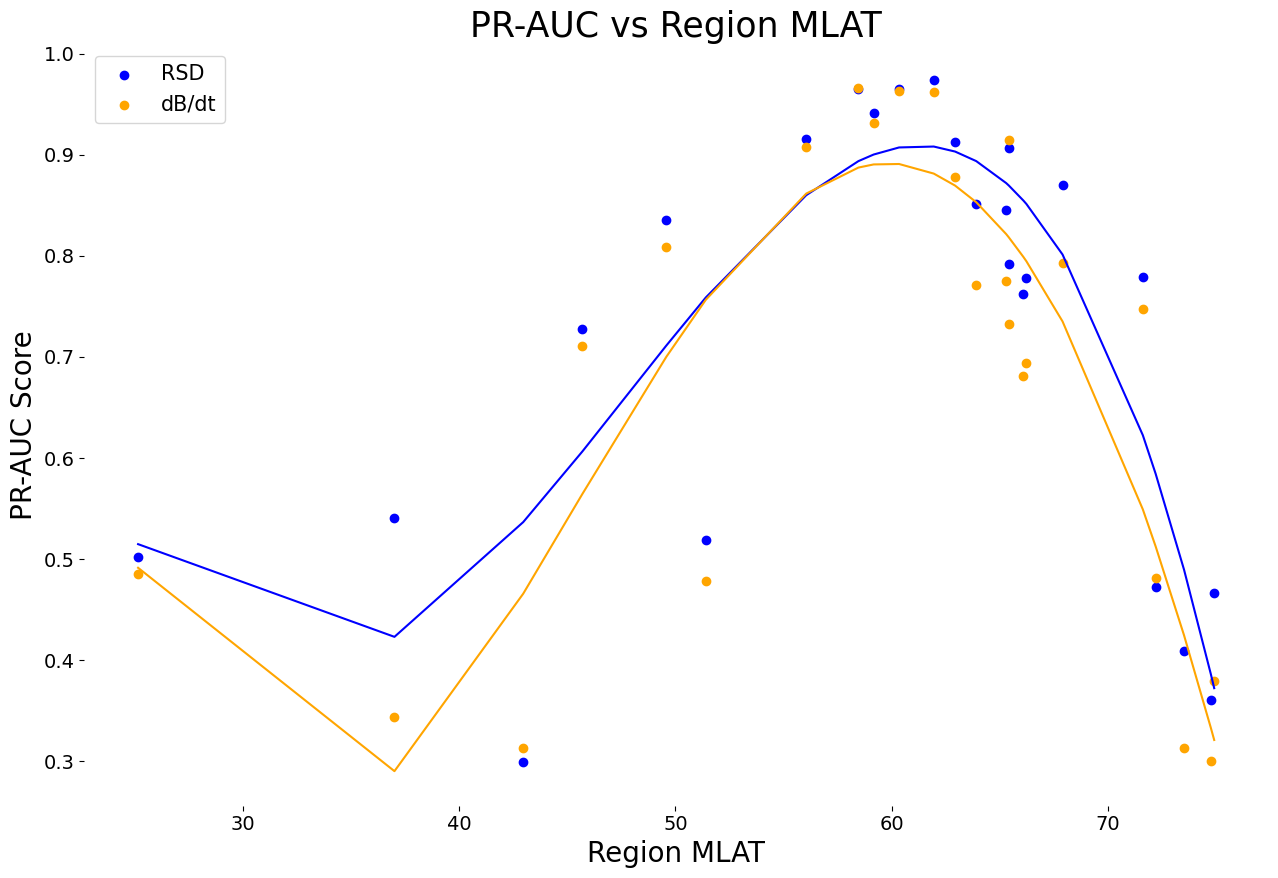

In [69]:
fig, axes = plt.subplots(1,1,figsize=(13,9))
# axes.scatter(swmag_plot_df['mean_lat'], swmag_plot_df['swmag_auc'], label='SWMAG', color='blue')
# axes.scatter(maxpool_plot_df['mean_lat'], maxpool_plot_df['twins_auc'], label='TWINS', color='orange')
# axes.scatter(alt_plot_df['mean_lat'], alt_plot_df['alt_auc'], label='new twins', color='green')
axes.scatter(alt_v2_plot_df['mean_lat'], alt_v2_plot_df['alt_v2_auc'], label='RSD', color='blue')
# axes.scatter(alt_v3_plot_df['mean_lat'], alt_v3_plot_df['alt_v3_auc'], label='new twins v3', color='black')
axes.scatter(dbht_plot_df['mean_lat'], dbht_plot_df['dbht_auc'], label='dB/dt', color='orange')

swmag_z = np.polyfit(swmag_plot_df['mean_lat'], swmag_plot_df['swmag_auc'], 4)
swmag_p = np.poly1d(swmag_z)
maxpool_z = np.polyfit(maxpool_plot_df['mean_lat'], maxpool_plot_df['twins_auc'], 4)
maxpool_p = np.poly1d(maxpool_z)
alt_z = np.polyfit(alt_plot_df['mean_lat'], alt_plot_df['alt_auc'], 4)
alt_p = np.poly1d(alt_z)
alt_v2_z = np.polyfit(alt_v2_plot_df['mean_lat'], alt_v2_plot_df['alt_v2_auc'], 4)
alt_v2_p = np.poly1d(alt_v2_z)
alt_v3_z = np.polyfit(alt_v3_plot_df['mean_lat'], alt_v3_plot_df['alt_v3_auc'], 4)
alt_v3_p = np.poly1d(alt_v3_z)
dbht_z = np.polyfit(dbht_plot_df['mean_lat'], dbht_plot_df['dbht_auc'], 4)
dbht_p = np.poly1d(dbht_z)

# axes.plot(swmag_plot_df['mean_lat'], swmag_p(swmag_plot_df['mean_lat']), color='blue')
# axes.plot(maxpool_plot_df['mean_lat'], maxpool_p(maxpool_plot_df['mean_lat']), color='orange')
# axes.plot(alt_plot_df['mean_lat'], alt_p(alt_plot_df['mean_lat']), color='green')
axes.plot(alt_v2_plot_df['mean_lat'], alt_v2_p(alt_v2_plot_df['mean_lat']), color='blue')
# axes.plot(alt_v3_plot_df['mean_lat'], alt_v3_p(alt_v3_plot_df['mean_lat']), color='black')
axes.plot(dbht_plot_df['mean_lat'], dbht_p(dbht_plot_df['mean_lat']), color='orange')

axes.set_xlabel('Region MLAT', fontsize=20)
axes.set_ylabel('PR-AUC Score', fontsize=20)
axes.set_title('PR-AUC vs Region MLAT', fontsize=25)
axes.legend(loc='upper left', fontsize=15)
plt.tight_layout()
plt.savefig(f'plots/GEM_2024_plots/pr-auc_vs_region_mlat_swmag_maxpool.png')

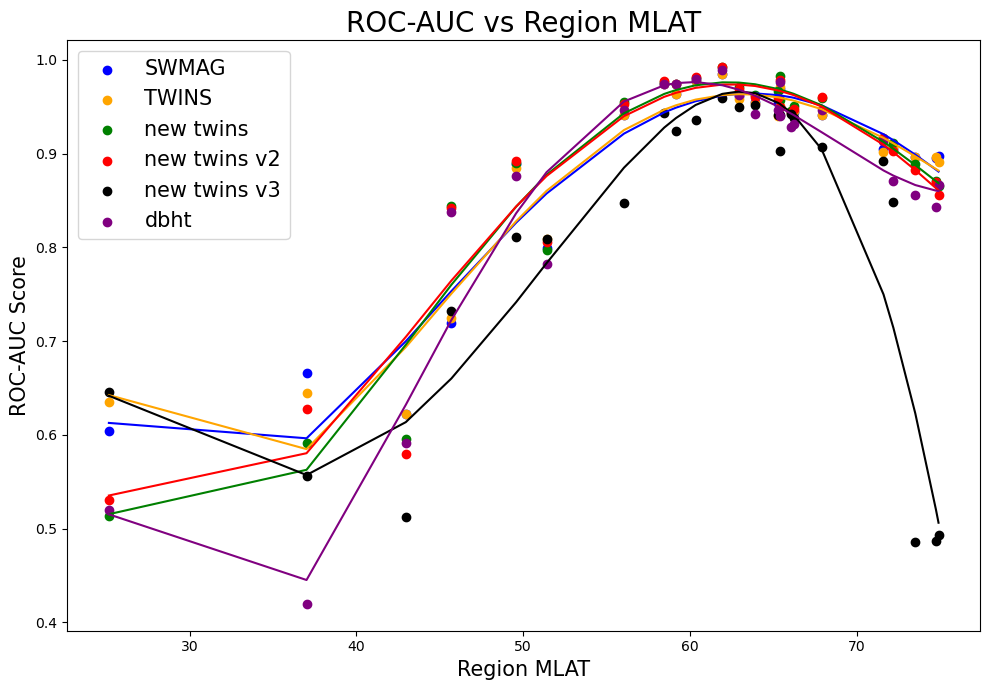

In [42]:
fig, axes = plt.subplots(1,1,figsize=(10,7))
axes.scatter(swmag_plot_df['mean_lat'], swmag_plot_df['swmag_roc'], label='SWMAG', color='blue')
axes.scatter(maxpool_plot_df['mean_lat'], maxpool_plot_df['twins_roc'], label='TWINS', color='orange')
axes.scatter(alt_plot_df['mean_lat'], alt_plot_df['alt_roc'], label='new twins', color='green')
axes.scatter(alt_v2_plot_df['mean_lat'], alt_v2_plot_df['alt_v2_roc'], label='new twins v2', color='red')
axes.scatter(alt_v3_plot_df['mean_lat'], alt_v3_plot_df['alt_v3_roc'], label='new twins v3', color='black')
axes.scatter(dbht_plot_df['mean_lat'], dbht_plot_df['dbht_roc'], label='dbht', color='purple')

swmag_z = np.polyfit(swmag_plot_df['mean_lat'], swmag_plot_df['swmag_roc'], 4)
swmag_p = np.poly1d(swmag_z)
maxpool_z = np.polyfit(maxpool_plot_df['mean_lat'], maxpool_plot_df['twins_roc'], 4)
maxpool_p = np.poly1d(maxpool_z)
alt_z = np.polyfit(alt_plot_df['mean_lat'], alt_plot_df['alt_roc'], 4)
alt_p = np.poly1d(alt_z)
alt_v2_z = np.polyfit(alt_v2_plot_df['mean_lat'], alt_v2_plot_df['alt_v2_roc'], 4)
alt_v2_p = np.poly1d(alt_v2_z)
alt_v3_z = np.polyfit(alt_v3_plot_df['mean_lat'], alt_v3_plot_df['alt_v3_roc'], 4)
alt_v3_p = np.poly1d(alt_v3_z)
dbht_z = np.polyfit(dbht_plot_df['mean_lat'], dbht_plot_df['dbht_roc'], 4)
dbht_p = np.poly1d(dbht_z)

axes.plot(swmag_plot_df['mean_lat'], swmag_p(swmag_plot_df['mean_lat']), color='blue')
axes.plot(maxpool_plot_df['mean_lat'], maxpool_p(maxpool_plot_df['mean_lat']), color='orange')
axes.plot(alt_plot_df['mean_lat'], alt_p(alt_plot_df['mean_lat']), color='green')
axes.plot(alt_v2_plot_df['mean_lat'], alt_v2_p(alt_v2_plot_df['mean_lat']), color='red')
axes.plot(alt_v3_plot_df['mean_lat'], alt_v3_p(alt_v3_plot_df['mean_lat']), color='black')
axes.plot(dbht_plot_df['mean_lat'], dbht_p(dbht_plot_df['mean_lat']), color='purple')

axes.set_xlabel('Region MLAT', fontsize=15)
axes.set_ylabel('ROC-AUC Score', fontsize=15)
axes.set_title('ROC-AUC vs Region MLAT', fontsize=20)
axes.legend(loc='upper left', fontsize=15)
plt.tight_layout()
plt.savefig(f'plots/roc-auc_vs_region_mlat_swmag_maxpool.png')

In [43]:
dbht_results_df = pd.DataFrame()
rsd_results_df = pd.DataFrame()
swmag_results_df = pd.DataFrame()
omni = utils.loading_solarwind()
for cluster in cluster_dict.keys():
	for key, value in results.items():
		if key not in cluster_dict[cluster]['regions']:
			continue
		# loading all the datasets and dictonaries
		RP = utils.RegionPreprocessing(cluster=cluster, region=key,
										features=['dbht', 'MAGNITUDE', 'theta', 'N', 'E', 'sin_theta', 'cos_theta'],
										mean=True, std=True, maximum=True, median=True,
										forecast=1, window=30, classification=True)
		df = RP()
		loc_df = utils.loading_supermag(value['mlt_station'])
		loc_df = loc_df[['MLAT']]
		if 'dbht' in value:
			temp_df = value['dbht'].set_index('dates')
			temp_df = temp_df.merge(df, how='left', left_index=True, right_index=True)
			temp_df = temp_df.merge(omni, how='left', left_index=True, right_index=True)
			temp_df = temp_df.merge(loc_df, how='left', left_index=True, right_index=True)
			dbht_results_df = pd.concat([dbht_results_df, temp_df])

		if 'twins_results' in value:
			temp_df = value['twins_results'].set_index('dates')
			temp_df = temp_df.merge(df, how='left', left_index=True, right_index=True)
			temp_df = temp_df.merge(omni, how='left', left_index=True, right_index=True)
			temp_df = temp_df.merge(loc_df, how='left', left_index=True, right_index=True)
			rsd_results_df = pd.concat([rsd_results_df, temp_df])
		if 'swmag_results' in value:
			temp_df = value['swmag_results'].set_index('dates')
			temp_df = temp_df.merge(df, how='left', left_index=True, right_index=True)
			temp_df = temp_df.merge(omni, how='left', left_index=True, right_index=True)
			temp_df = temp_df.merge(loc_df, how='left', left_index=True, right_index=True)
			swmag_results_df = pd.concat([swmag_results_df, temp_df])

bins = [0,3,6,9,12,15,18,21,24]

# dbht_results_df['MLT'] = pd.cut(dbht_results_df['MLT'], bins=bins, labels=[i for i in range(len(bins)-1)], include_lowest=True)
# rsd_results_df['MLT'] = pd.cut(rsd_results_df['MLT'], bins=bins, labels=[i for i in range(len(bins)-1)], include_lowest=True)
# swmag_results_df['MLT'] = pd.cut(swmag_results_df['MLT'], bins=bins, labels=[i for i in range(len(bins)-1)], include_lowest=True)

# dbht_results_df.dropna(inplace=True, subset=['MLT'])
# rsd_results_df.dropna(inplace=True, subset=['MLT'])
# swmag_results_df.dropna(inplace=True, subset=['MLT'])

# dbht_results_df['MLT'] = dbht_results_df['MLT'].astype(int)
# rsd_results_df['MLT'] = rsd_results_df['MLT'].astype(int)
# swmag_results_df['MLT'] = swmag_results_df['MLT'].astype(int)

# replaceing nan with 0
dbht_results_df['MLT'] = dbht_results_df['MLT'].round(0)
rsd_results_df['MLT'] = rsd_results_df['MLT'].round(0)
swmag_results_df['MLT'] = swmag_results_df['MLT'].round(0)
# dbht_results_df['MLT'] = np.floor(dbht_results_df['MLT'])
# rsd_results_df['MLT'] = np.floor(rsd_results_df['MLT'])
# swmag_results_df['MLT'] = np.floor(swmag_results_df['MLT'])

# changing teh values of 24 to 0
dbht_results_df.loc[dbht_results_df['MLT'] == 24, 'MLT'] = 0
rsd_results_df.loc[rsd_results_df['MLT'] == 24, 'MLT'] = 0
swmag_results_df.loc[swmag_results_df['MLT'] == 24, 'MLT'] = 0

Loading solar wind data....
Forecast: 1, Window: 30, Classification: True
Loading station NEW....
Loading station T19....
Loading station C10....
Loading station LET....
Loading station T03....
Loading station T43....
region keys: dict_keys(['stations', 'mlt_station'])
MLT station already defined for region CAN-0


/home/mcoughlan/projects/including_ion_temp_maps/utils.py:471: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  max_station = rsd.idxmax(axis=1)


Loading station NEW....
Forecast: 1, Window: 30, Classification: True
Loading station LET....
Loading station T03....
Loading station T43....
Loading station RED....
Loading station C06....
region keys: dict_keys(['stations', 'mlt_station'])
MLT station already defined for region CAN-1


/home/mcoughlan/projects/including_ion_temp_maps/utils.py:471: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  max_station = rsd.idxmax(axis=1)


Loading station LET....
Forecast: 1, Window: 30, Classification: True
Loading station T43....
Loading station RED....
Loading station C06....
Loading station MEA....
Loading station T36....
region keys: dict_keys(['stations', 'mlt_station'])
MLT station already defined for region CAN-2


/home/mcoughlan/projects/including_ion_temp_maps/utils.py:471: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  max_station = rsd.idxmax(axis=1)


Loading station MEA....
Forecast: 1, Window: 30, Classification: True
Loading station GHB....
Loading station SKT....
Loading station STF....
Loading station ATU....
region keys: dict_keys(['stations', 'mlt_station'])
MLT station already defined for region GRL-0


/home/mcoughlan/projects/including_ion_temp_maps/utils.py:471: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  max_station = rsd.idxmax(axis=1)


Loading station STF....
Forecast: 1, Window: 30, Classification: True
Loading station SKT....
Loading station STF....
Loading station ATU....
Loading station GDH....
region keys: dict_keys(['stations', 'mlt_station'])
MLT station already defined for region GRL-1


/home/mcoughlan/projects/including_ion_temp_maps/utils.py:471: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  max_station = rsd.idxmax(axis=1)


Loading station GDH....
Forecast: 1, Window: 30, Classification: True
Loading station STF....
Loading station ATU....
Loading station GDH....
Loading station UMQ....
region keys: dict_keys(['stations', 'mlt_station'])
MLT station already defined for region GRL-2


/home/mcoughlan/projects/including_ion_temp_maps/utils.py:471: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  max_station = rsd.idxmax(axis=1)


Loading station GDH....
Forecast: 1, Window: 30, Classification: True
Loading station GHB....
Loading station FHB....
Loading station NAQ....
region keys: dict_keys(['stations', 'mlt_station'])
MLT station already defined for region GRL-3


/home/mcoughlan/projects/including_ion_temp_maps/utils.py:471: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  max_station = rsd.idxmax(axis=1)


Loading station NAQ....
Forecast: 1, Window: 30, Classification: True
Loading station RVK....
Loading station LYC....
Loading station DON....
Loading station JCK....
region keys: dict_keys(['stations', 'mlt_station'])
MLT station already defined for region FSC-0


/home/mcoughlan/projects/including_ion_temp_maps/utils.py:471: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  max_station = rsd.idxmax(axis=1)


Loading station LYC....
Forecast: 1, Window: 30, Classification: True
Loading station HAN....
Loading station MEK....
Loading station OUJ....
Loading station NUR....
region keys: dict_keys(['stations', 'mlt_station'])
MLT station already defined for region FSC-1


/home/mcoughlan/projects/including_ion_temp_maps/utils.py:471: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  max_station = rsd.idxmax(axis=1)


Loading station NUR....
Forecast: 1, Window: 30, Classification: True
Loading station MAS....
Loading station NOR....
Loading station IVA....
Loading station KEV....
Loading station KIL....
Loading station MUO....
Loading station SOR....
Loading station TRO....
Loading station ABK....
Loading station KIR....
region keys: dict_keys(['stations', 'mlt_station'])
MLT station already defined for region FSC-2


/home/mcoughlan/projects/including_ion_temp_maps/utils.py:471: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  max_station = rsd.idxmax(axis=1)


Loading station ABK....
Forecast: 1, Window: 30, Classification: True
Loading station MAS....
Loading station AND....
Loading station KIL....
Loading station MUO....
Loading station SOR....
Loading station TRO....
Loading station ABK....
Loading station KIR....
region keys: dict_keys(['stations', 'mlt_station'])
MLT station already defined for region FSC-3


/home/mcoughlan/projects/including_ion_temp_maps/utils.py:471: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  max_station = rsd.idxmax(axis=1)


Loading station ABK....
Forecast: 1, Window: 30, Classification: True
Loading station MAS....
Loading station SOD....
Loading station IVA....
Loading station KEV....
Loading station KIL....
Loading station MUO....
Loading station ABK....
Loading station KIR....
Loading station PEL....
region keys: dict_keys(['stations', 'mlt_station'])
MLT station already defined for region FSC-4


/home/mcoughlan/projects/including_ion_temp_maps/utils.py:471: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  max_station = rsd.idxmax(axis=1)


Loading station ABK....
Forecast: 1, Window: 30, Classification: True
Loading station JCK....
Loading station DON....
Loading station ABK....
Loading station KIR....
Loading station LYC....
region keys: dict_keys(['stations', 'mlt_station'])
MLT station already defined for region FSC-5


/home/mcoughlan/projects/including_ion_temp_maps/utils.py:471: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  max_station = rsd.idxmax(axis=1)


Loading station ABK....
Forecast: 1, Window: 30, Classification: True
Loading station MAS....
Loading station AND....
Loading station KIL....
Loading station MUO....
Loading station JCK....
Loading station TRO....
Loading station ABK....
Loading station KIR....
Loading station PEL....
region keys: dict_keys(['stations', 'mlt_station'])
MLT station already defined for region FSC-6


/home/mcoughlan/projects/including_ion_temp_maps/utils.py:471: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  max_station = rsd.idxmax(axis=1)


Loading station ABK....
Forecast: 1, Window: 30, Classification: True
Loading station ZAG....
Loading station LVV....
Loading station BEL....
Loading station VYH....
region keys: dict_keys(['stations', 'mlt_station'])
MLT station already defined for region CEU-0


/home/mcoughlan/projects/including_ion_temp_maps/utils.py:471: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  max_station = rsd.idxmax(axis=1)


Loading station BEL....
Forecast: 1, Window: 30, Classification: True
Loading station BEL....
Loading station HLP....
Loading station SZC....
Loading station KLD....
region keys: dict_keys(['stations', 'mlt_station'])
MLT station already defined for region CEU-1


/home/mcoughlan/projects/including_ion_temp_maps/utils.py:471: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  max_station = rsd.idxmax(axis=1)


Loading station BEL....
Forecast: 1, Window: 30, Classification: True
Loading station THY....
Loading station BDV....
Loading station WIC....
Loading station NCK....
Loading station HRB....
region keys: dict_keys(['stations', 'mlt_station'])
MLT station already defined for region CEU-2


/home/mcoughlan/projects/including_ion_temp_maps/utils.py:471: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  max_station = rsd.idxmax(axis=1)


Loading station HRB....
Forecast: 1, Window: 30, Classification: True
Loading station ROE....
Loading station BFE....
Loading station WNG....
region keys: dict_keys(['stations', 'mlt_station'])
MLT station already defined for region CEU-3


/home/mcoughlan/projects/including_ion_temp_maps/utils.py:471: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  max_station = rsd.idxmax(axis=1)


Loading station WNG....
Forecast: 1, Window: 30, Classification: True
Loading station BBG....
Loading station LYR....
Loading station HOR....
Loading station NAL....
Loading station HRN....
Loading station HOP....
region keys: dict_keys(['stations', 'mlt_station'])
MLT station already defined for region SVLB


/home/mcoughlan/projects/including_ion_temp_maps/utils.py:471: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  max_station = rsd.idxmax(axis=1)


Loading station HRN....
Forecast: 1, Window: 30, Classification: True
Loading station KUJ....
Loading station KNY....
Loading station KAG....
region keys: dict_keys(['stations', 'mlt_station'])
MLT station already defined for region JPN-0


/home/mcoughlan/projects/including_ion_temp_maps/utils.py:471: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  max_station = rsd.idxmax(axis=1)


Loading station KNY....
Forecast: 1, Window: 30, Classification: True
Loading station MMB....
Loading station ASB....
Loading station RIK....
Loading station MSR....
region keys: dict_keys(['stations', 'mlt_station'])
MLT station already defined for region JPN-1


/home/mcoughlan/projects/including_ion_temp_maps/utils.py:471: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  max_station = rsd.idxmax(axis=1)


Loading station MMB....
Forecast: 1, Window: 30, Classification: True
Loading station CMO....
Loading station FYU....
Loading station PKR....
Loading station GAK....
region keys: dict_keys(['stations', 'mlt_station'])
MLT station already defined for region ALSK


/home/mcoughlan/projects/including_ion_temp_maps/utils.py:471: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  max_station = rsd.idxmax(axis=1)


Loading station CMO....
Forecast: 1, Window: 30, Classification: True
Loading station PIN....
Loading station ISL....
Loading station C05....
region keys: dict_keys(['stations', 'mlt_station'])
MLT station already defined for region HUD-0


/home/mcoughlan/projects/including_ion_temp_maps/utils.py:471: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  max_station = rsd.idxmax(axis=1)


Loading station PIN....
Forecast: 1, Window: 30, Classification: True
Loading station FCC....
Loading station EKP....
Loading station RAN....
Loading station BLC....
region keys: dict_keys(['stations', 'mlt_station'])
MLT station already defined for region HUD-1


/home/mcoughlan/projects/including_ion_temp_maps/utils.py:471: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  max_station = rsd.idxmax(axis=1)


Loading station BLC....


In [44]:
lower_lat_bound = 55
upper_lat_bound = 65

low_dbht_results_df = dbht_results_df[dbht_results_df['MLAT'] < lower_lat_bound]
low_rsd_results_df = rsd_results_df[rsd_results_df['MLAT'] < lower_lat_bound]
low_swmag_results_df = swmag_results_df[swmag_results_df['MLAT'] < lower_lat_bound]

mid_dbht_results_df = dbht_results_df[(dbht_results_df['MLAT'] >= lower_lat_bound) & (dbht_results_df['MLAT'] <= upper_lat_bound)]
mid_rsd_results_df = rsd_results_df[(rsd_results_df['MLAT'] >= lower_lat_bound) & (rsd_results_df['MLAT'] <= upper_lat_bound)]
mid_swmag_results_df = swmag_results_df[(swmag_results_df['MLAT'] >= lower_lat_bound) & (swmag_results_df['MLAT'] <= upper_lat_bound)]

high_dbht_results_df = dbht_results_df[dbht_results_df['MLAT'] > upper_lat_bound]
high_rsd_results_df = rsd_results_df[rsd_results_df['MLAT'] > upper_lat_bound]
high_swmag_results_df = swmag_results_df[swmag_results_df['MLAT'] > upper_lat_bound]

dbht_dict, rsd_dict, swmag_dict = {},{},{}
dbht_list, rsd_list, swmag_list, names = [low_dbht_results_df, mid_dbht_results_df, high_dbht_results_df], \
											[low_rsd_results_df, mid_rsd_results_df, high_rsd_results_df], \
											[low_swmag_results_df, mid_swmag_results_df, high_swmag_results_df], \
											['low', 'mid', 'high']

for i, (dbht_df, rsd_df, swmag_df, name) in enumerate(zip(dbht_list, rsd_list, swmag_list, names)):
	dbht_dict[name], rsd_dict[name], swmag_dict[name] = {}, {}, {}
	for j in range(0, 24):
		dbht_dict[name][j], rsd_dict[name][j], swmag_dict[name][j] = {}, {}, {}
		dbht_temp = dbht_df[dbht_df['MLT'] == j]
		# calculating the PRAUC 
		prec, rec, __ = precision_recall_curve(dbht_temp['actual'], dbht_temp['predicted_mean'])
		dbht_dict[name][j]['prauc'] = auc(rec, prec).astype(np.float32)
		# calculating the ROC AUC
		fpr, tpr, __ = roc_curve(dbht_temp['actual'], dbht_temp['predicted_mean'])
		dbht_dict[name][j]['rocauc'] = auc(fpr, tpr).astype(np.float32)

		dbht_dict[name][j]['rmse'] = mean_squared_error(dbht_temp['actual'], dbht_temp['predicted_mean'], squared=False).astype(np.float32)

		rsd_temp = rsd_df[rsd_df['MLT'] == j]
		# calculating the PRAUC
		prec, rec, __ = precision_recall_curve(rsd_temp['actual'], rsd_temp['predicted_mean'])
		rsd_dict[name][j]['prauc'] = auc(rec, prec).astype(np.float32)
		# calculating the ROC AUC
		fpr, tpr, __ = roc_curve(rsd_temp['actual'], rsd_temp['predicted_mean'])
		rsd_dict[name][j]['rocauc'] = auc(fpr, tpr).astype(np.float32)

		rsd_dict[name][j]['rmse'] = mean_squared_error(rsd_temp['actual'], rsd_temp['predicted_mean'], squared=False).astype(np.float32)

		swmag_temp = swmag_df[swmag_df['MLT'] == j]
		# calculating the PRAUC
		prec, rec, __ = precision_recall_curve(swmag_temp['actual'], swmag_temp['predicted_mean'])
		swmag_dict[name][j]['prauc'] = auc(rec, prec).astype(np.float32)
		# calculating the ROC AUC
		fpr, tpr, __ = roc_curve(swmag_temp['actual'], swmag_temp['predicted_mean'])
		swmag_dict[name][j]['rocauc'] = auc(fpr, tpr).astype(np.float32)

		swmag_dict[name][j]['rmse'] = mean_squared_error(swmag_temp['actual'], swmag_temp['predicted_mean'], squared=False).astype(np.float32)

# test_lat = 'high'
# test_mlt = 11
# test_df = high_dbht_results_df[high_dbht_results_df["MLT"] == test_mlt]
# print(f'ROC AUC for DBHT at {test_lat} lat and {test_mlt} MLT: {dbht_dict[test_lat][test_mlt]["rocauc"]}')
# print(f'PRAUC for RSD at {test_lat} lat and {test_mlt} MLT: {rsd_dict[test_lat][test_mlt]["prauc"]}')
# print(f'dataframe: {test_df}')
# print(f'Sum of actual: {test_df["actual"].sum()}')
# print(f'segmented positive: {test_df[test_df["actual"] == 1]}')
# print(f'Max predicted mean: {test_df["predicted_mean"].max()}')
# fpr, tpr, __ = roc_curve(test_df["actual"], test_df["predicted_mean"])
# # getting precision and recall
# prec, rec, __ = precision_recall_curve(test_df["actual"], test_df["predicted_mean"])
# print(f'fpr: {fpr}')
# print(f'tpr: {tpr}')
# print(f'ROC AUC: {auc(fpr, tpr).astype(np.float32)}')
# print(f'Precision: {prec}')
# print(f'Recall: {rec}')
# print(f'PRAUC: {auc(rec, prec).astype(np.float32)}')

# plt.scatter(fpr, tpr)
# plt.scatter(rec, prec)
# plt.show()



/home/mcoughlan/anaconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/mcoughlan/anaconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


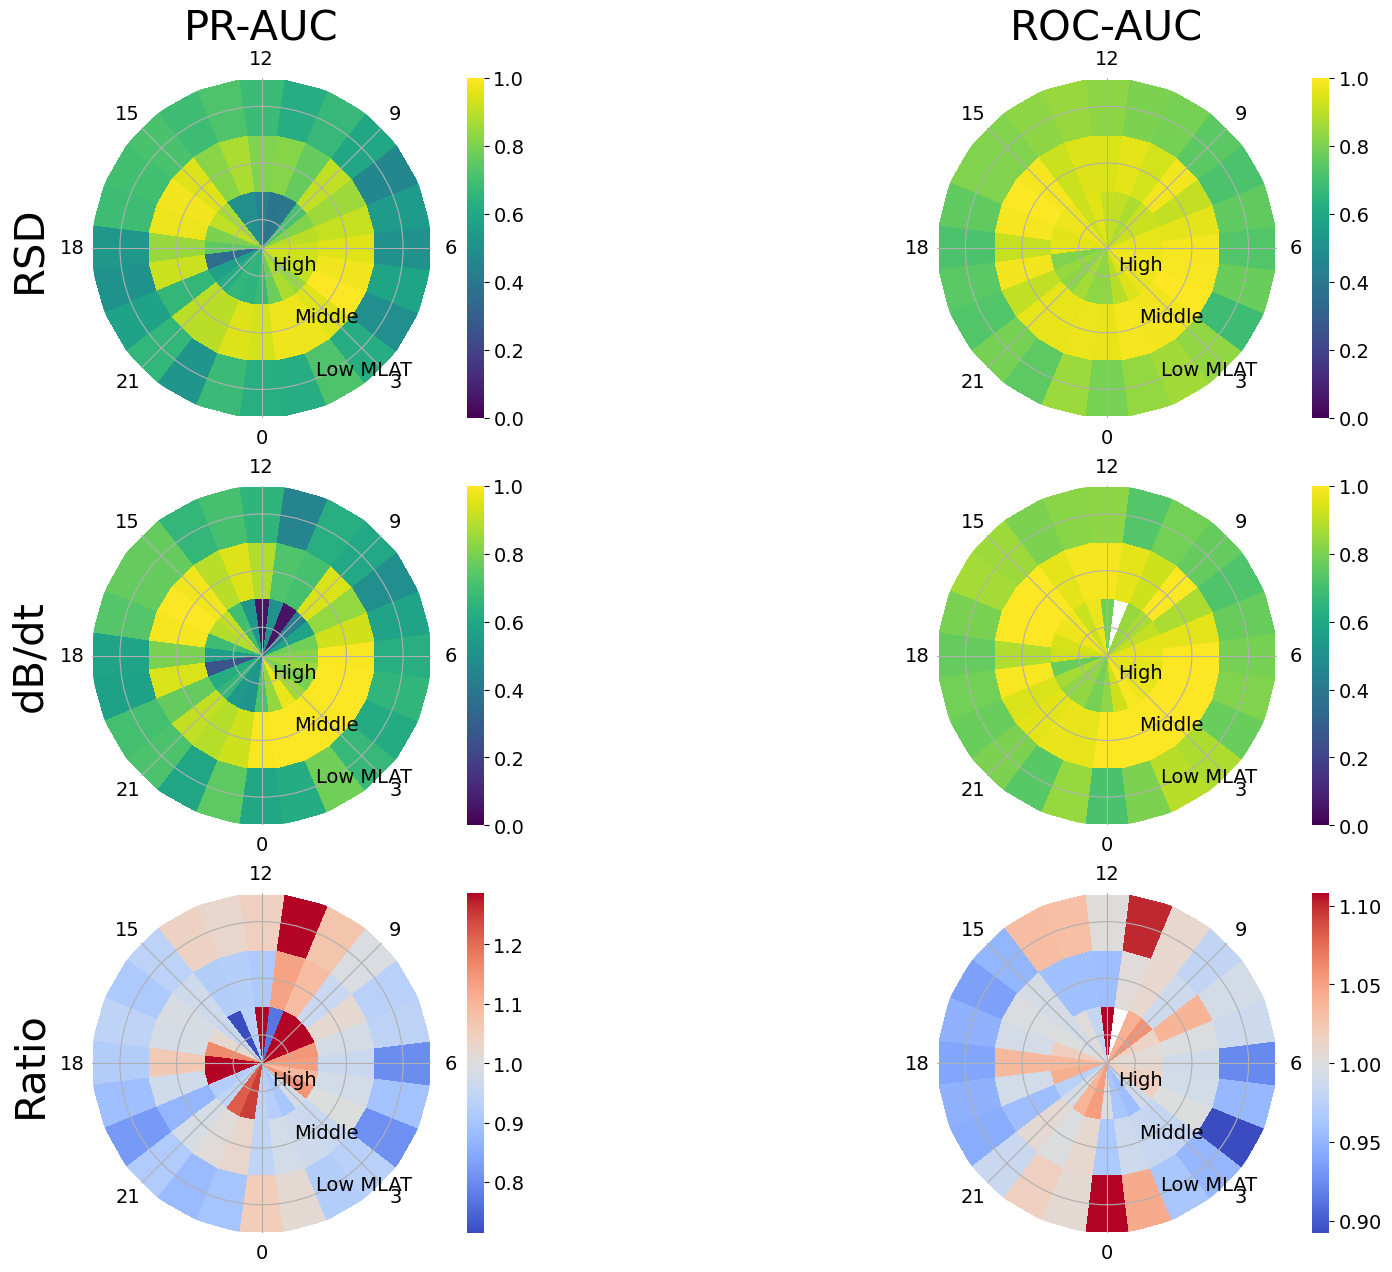

In [66]:
# printing the results for the prauc and rocauc for the dbht and rsd models as a heatmap

pr_dbht_df = pd.DataFrame(index = range(24), columns = ['low', 'mid', 'high'])
roc_dbht_df = pd.DataFrame(index = range(24), columns = ['low', 'mid', 'high'])
rmse_dbht_df = pd.DataFrame(index = range(24), columns = ['low', 'mid', 'high'])
pr_rsd_df = pd.DataFrame(index = range(24), columns = ['low', 'mid', 'high'])
roc_rsd_df = pd.DataFrame(index = range(24), columns = ['low', 'mid', 'high'])
rmse_rsd_df = pd.DataFrame(index = range(24), columns = ['low', 'mid', 'high'])
pr_swmag_df = pd.DataFrame(index = range(24), columns = ['low', 'mid', 'high'])
roc_swmag_df = pd.DataFrame(index = range(24), columns = ['low', 'mid', 'high'])
rmse_swmag_df = pd.DataFrame(index = range(24), columns = ['low', 'mid', 'high'])


for i, (dbht_df, rsd_df, swmag_df, name) in enumerate(zip(dbht_list, rsd_list, swmag_list, names)):
	for j in range(0,24):
		pr_dbht_df.loc[j, name] = dbht_dict[name][j]['prauc']
		roc_dbht_df.loc[j, name] = dbht_dict[name][j]['rocauc']
		rmse_dbht_df.loc[j, name] = dbht_dict[name][j]['rmse']
		pr_rsd_df.loc[j, name] = rsd_dict[name][j]['prauc']
		roc_rsd_df.loc[j, name] = rsd_dict[name][j]['rocauc']
		rmse_rsd_df.loc[j, name] = rsd_dict[name][j]['rmse']
		pr_swmag_df.loc[j, name] = swmag_dict[name][j]['prauc']
		roc_swmag_df.loc[j, name] = swmag_dict[name][j]['rocauc']
		rmse_swmag_df.loc[j, name] = swmag_dict[name][j]['rmse']

# convertin the values to float
pr_dbht_df = pr_dbht_df.astype(float)
roc_dbht_df = roc_dbht_df.astype(float)
rmse_dbht_df = rmse_dbht_df.astype(float)
pr_rsd_df = pr_rsd_df.astype(float)
roc_rsd_df = roc_rsd_df.astype(float)
rmse_rsd_df = rmse_rsd_df.astype(float)
pr_swmag_df = pr_swmag_df.astype(float)
roc_swmag_df = roc_swmag_df.astype(float)
rmse_swmag_df = rmse_swmag_df.astype(float)

plotting_norm = mpl.colors.Normalize(vmin=00, vmax=1)

# plotting the results as polar heatmap with MLT=12 at the top of the plot, low mid and high as three different rings
rad = [0,1,2]
theta_ticks = np.linspace(0, 2*np.pi, 8, endpoint=False)
theta_labels = ['0', '3', '6', '9', '12', '15', '18', '21']

# setting global plotting params
mpl.rcParams['axes.linewidth'] = 0
mpl.rcParams['font.size'] = 14
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['xtick.labelsize'] = 14

fig, axs = plt.subplots(3, 2, figsize=(20, 15), subplot_kw=dict(projection='polar'))
# fig.suptitle('Metrics', fontsize=30)

# # Plotting the PR-AUC scores on a polar plot
# axs[0,0].set_theta_zero_location('S')
# r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
# cbar = fig.colorbar(axs[0,0].pcolormesh(th, r, pr_swmag_df, cmap='magma', norm=plotting_norm), ax=axs[0,0])
# axs[0,0].set_title('SWMAG PR-AUC')
# axs[0,0].invert_yaxis()
# axs[0,0].set_xticks(theta_ticks)
# axs[0,0].set_xticklabels(theta_labels)
# axs[0,0].set_yticks([])

axs[0,0].set_theta_zero_location('S')
r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
cbar = fig.colorbar(axs[0,0].pcolormesh(th, r, pr_rsd_df, cmap='viridis', norm=plotting_norm), ax=axs[0,0])
axs[0,0].set_title('PR-AUC', fontsize=30)
axs[0,0].invert_yaxis()
axs[0,0].set_xticks(theta_ticks)
axs[0,0].set_xticklabels(theta_labels)
axs[0,0].set_ylabel('RSD', labelpad=30, fontsize=30)
axs[0,0].set_yticks(rad)
axs[0,0].set_yticklabels(['Low MLAT', 'Middle', 'High'])

axs[1,0].set_theta_zero_location('S')
r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
cbar = fig.colorbar(axs[1,0].pcolormesh(th, r, pr_dbht_df, cmap='viridis', norm=plotting_norm), ax=axs[1,0])
# axs[1,0].set_title('PR-AUC')
axs[1,0].invert_yaxis()
axs[1,0].set_xticks(theta_ticks)
axs[1,0].set_xticklabels(theta_labels)
axs[1,0].set_ylabel('dB/dt', labelpad=30, fontsize=30)
axs[1,0].set_yticks(rad)
axs[1,0].set_yticklabels(['Low MLAT', 'Middle', 'High'])

axs[2,0].set_theta_zero_location('S')
r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
twins_div_dbht_pr_df = pr_rsd_df / pr_dbht_df
vmin = twins_div_dbht_pr_df.min().min()
vmax = twins_div_dbht_pr_df.max().max()
scale = max(1-abs(vmin), abs(vmin)-1)
plotting_norm = mpl.colors.Normalize(vmin=1-scale, vmax=1+scale)
# plotting_norm = None
cbar = fig.colorbar(axs[2,0].pcolormesh(th, r, twins_div_dbht_pr_df, cmap='coolwarm', norm=plotting_norm), ax=axs[2,0])
# axs[2,0].set_title('Twins RSD / dB/dt PR-AUC')
axs[2,0].invert_yaxis()
axs[2,0].set_xticks(theta_ticks)
axs[2,0].set_xticklabels(theta_labels)
axs[2,0].set_ylabel('Ratio', labelpad=30, fontsize=30)
axs[2,0].set_yticks(rad)
axs[2,0].set_yticklabels(['Low MLAT', 'Middle', 'High'])

# # Plotting the ROC-AUC scores on a polar plot
# axs[1,0].set_theta_zero_location('S')
# r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
# cbar = fig.colorbar(axs[1,0].pcolormesh(th, r, roc_swmag_df, cmap='magma', norm=plotting_norm), ax=axs[1,0])
# axs[1,0].set_title('SWMAG ROC-AUC')
# axs[1,0].invert_yaxis()
# axs[1,0].set_xticks(theta_ticks)
# axs[1,0].set_xticklabels(theta_labels)
# axs[1,0].set_yticks([])
plotting_norm=mpl.colors.Normalize(vmin=0, vmax=1)
axs[0,1].set_theta_zero_location('S')
r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
cbar = fig.colorbar(axs[0,1].pcolormesh(th, r, roc_rsd_df, cmap='viridis', norm=plotting_norm), ax=axs[0,1])
axs[0,1].set_title('ROC-AUC', fontsize=30)
axs[0,1].invert_yaxis()
axs[0,1].set_xticks(theta_ticks)
axs[0,1].set_xticklabels(theta_labels)
axs[0,1].set_yticks(rad)
axs[0,1].set_yticklabels(['Low MLAT', 'Middle', 'High'])

axs[1,1].set_theta_zero_location('S')
r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
cbar = fig.colorbar(axs[1,1].pcolormesh(th, r, roc_dbht_df, cmap='viridis', norm=plotting_norm), ax=axs[1,1])
# axs[1,1].set_title('ROC-AUC')
axs[1,1].invert_yaxis()
axs[1,1].set_xticks(theta_ticks)
axs[1,1].set_xticklabels(theta_labels)
axs[1,1].set_yticks(rad)
axs[1,1].set_yticklabels(['Low MLAT', 'Middle', 'High'])

axs[2,1].set_theta_zero_location('S')
r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
twins_div_dbht_roc_df = roc_rsd_df / roc_dbht_df
vmin = twins_div_dbht_roc_df.min().min()
# vmax = twins_div_dbht_roc_df.max().max()
scale = max(1-abs(vmin), abs(vmin)-1)
plotting_norm = mpl.colors.Normalize(vmin=1-scale, vmax=1+scale)
# plotting_norm = None
cbar = fig.colorbar(axs[2,1].pcolormesh(th, r, twins_div_dbht_roc_df, cmap='coolwarm', norm=plotting_norm), ax=axs[2,1])
# axs[2,1].set_title('Twins RSD / dB/dt ROC-AUC')
axs[2,1].invert_yaxis()
axs[2,1].set_xticks(theta_ticks)
axs[2,1].set_xticklabels(theta_labels)
axs[2,1].set_yticks(rad)
axs[2,1].set_yticklabels(['Low MLAT', 'Middle', 'High'])


# # Plotting the RMSE scores on a polar plot
# axs[2,0].set_theta_zero_location('S')
# r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
# cbar = fig.colorbar(axs[2,0].pcolormesh(th, r, rmse_swmag_df, cmap='magma'), ax=axs[2,0])
# axs[2,0].set_title('SWMAG RMSE')
# axs[2,0].invert_yaxis()
# axs[2,0].set_xticks(theta_ticks)
# axs[2,0].set_xticklabels(theta_labels)
# axs[2,0].set_yticks([])
# cbar.set_label('RMSE')

# axs[2,1].set_theta_zero_location('S')
# r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
# cbar = fig.colorbar(axs[2,1].pcolormesh(th, r, rmse_rsd_df, cmap='magma'), ax=axs[2,1])
# axs[2,1].set_title('RSD RMSE')
# axs[2,1].invert_yaxis()
# axs[2,1].set_xticks(theta_ticks)
# axs[2,1].set_xticklabels(theta_labels)
# axs[2,1].set_yticks([])
# cbar.set_label('RMSE')

# axs[2,2].set_theta_zero_location('S')
# r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
# cbar = fig.colorbar(axs[2,2].pcolormesh(th, r, rmse_dbht_df, cmap='magma'), ax=axs[2,2])
# axs[2,2].set_title('db/dt RMSE')
# axs[2,2].invert_yaxis()
# axs[2,2].set_xticks(theta_ticks)
# axs[2,2].set_xticklabels(theta_labels)
# axs[2,2].set_yticks([])
# cbar.set_label('RMSE')

plt.savefig('plots/GEM_2024_plots/metrics_polar_heatmap.png')


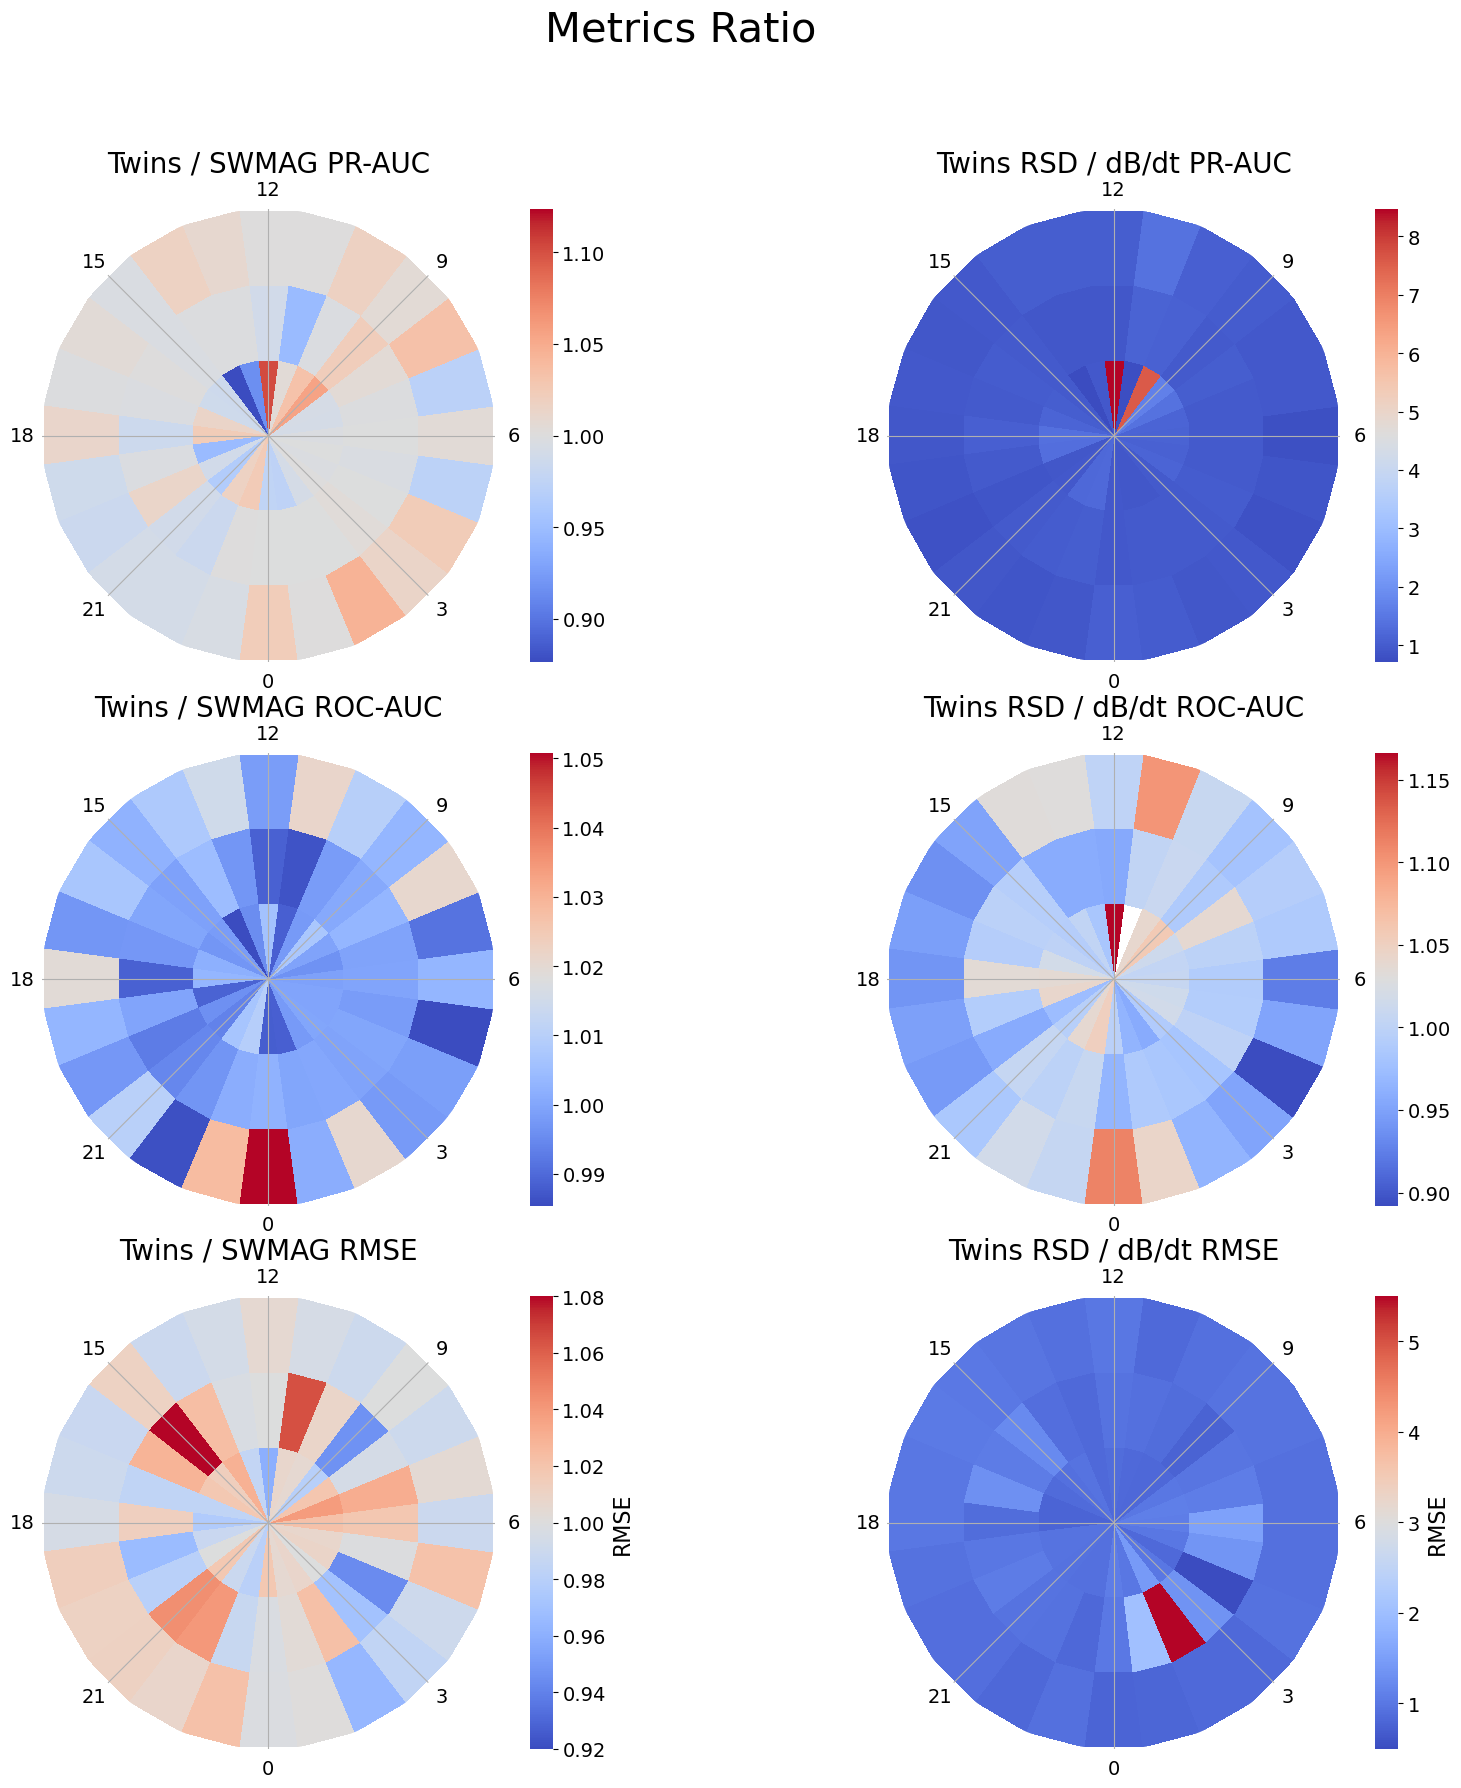

In [144]:

# plotting_norm = mpl.colors.Normalize(vmin=0.5, vmax=1.5)
plotting_norm = None

# plotting the results as polar heatmap with MLT=12 at the top of the plot, low mid and high as three different rings
rad = [0,1,2]
theta_ticks = np.linspace(0, 2*np.pi, 8, endpoint=False)
theta_labels = ['0', '3', '6', '9', '12', '15', '18', '21']

# setting global plotting params
mpl.rcParams['axes.linewidth'] = 0
mpl.rcParams['font.size'] = 14
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['xtick.labelsize'] = 14

fig, axs = plt.subplots(3, 2, figsize=(20,20), subplot_kw=dict(projection='polar'))
fig.suptitle('Metrics Ratio', fontsize=30)

# Plotting the PR-AUC scores on a polar plot
axs[0,0].set_theta_zero_location('S')
r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
twins_div_swmag_pr_df = pr_rsd_df / pr_swmag_df
vmin = twins_div_swmag_pr_df.min().min()
vmax = twins_div_swmag_pr_df.max().max()
scale = max(abs(vmin-1), abs(vmax-1))
plotting_norm = mpl.colors.Normalize(vmin=1-scale, vmax=1+scale)
# plotting_norm = None
cbar = fig.colorbar(axs[0,0].pcolormesh(th, r, twins_div_swmag_pr_df, cmap='coolwarm', norm=plotting_norm), ax=axs[0,0])
axs[0,0].set_title('Twins / SWMAG PR-AUC')
axs[0,0].invert_yaxis()
axs[0,0].set_xticks(theta_ticks)
axs[0,0].set_xticklabels(theta_labels)
axs[0,0].set_yticks([])

axs[0,1].set_theta_zero_location('S')
r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
twins_div_dbht_pr_df = pr_rsd_df / pr_dbht_df
vmin = twins_div_dbht_pr_df.min().min()
vmax = twins_div_dbht_pr_df.max().max()
scale = max(abs(vmin), abs(vmax))
# plotting_norm = mpl.colors.Normalize(vmin=-scale, vmax=scale)
plotting_norm = None
cbar = fig.colorbar(axs[0,1].pcolormesh(th, r, twins_div_dbht_pr_df, cmap='coolwarm', norm=plotting_norm), ax=axs[0,1])
axs[0,1].set_title('Twins RSD / dB/dt PR-AUC')
axs[0,1].invert_yaxis()
axs[0,1].set_xticks(theta_ticks)
axs[0,1].set_xticklabels(theta_labels)
axs[0,1].set_yticks([])

# Plotting the PR-AUC scores on a polar plot
axs[1,0].set_theta_zero_location('S')
r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
twins_div_swmag_roc_df = roc_rsd_df / roc_swmag_df
vmin = twins_div_swmag_roc_df.min().min()
vmax = twins_div_swmag_roc_df.max().max()
scale = max(abs(vmin), abs(vmax))
# plotting_norm = mpl.colors.Normalize(vmin=-scale, vmax=scale)
plotting_norm = None
cbar = fig.colorbar(axs[1,0].pcolormesh(th, r, twins_div_swmag_roc_df, cmap='coolwarm', norm=plotting_norm), ax=axs[1,0])
axs[1,0].set_title('Twins / SWMAG ROC-AUC')
axs[1,0].invert_yaxis()
axs[1,0].set_xticks(theta_ticks)
axs[1,0].set_xticklabels(theta_labels)
axs[1,0].set_yticks([])

axs[1,1].set_theta_zero_location('S')
r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
twins_div_dbht_roc_df = roc_rsd_df / roc_dbht_df
vmin = twins_div_dbht_roc_df.min().min()
vmax = twins_div_dbht_roc_df.max().max()
scale = max(abs(vmin), abs(vmax))
# plotting_norm = mpl.colors.Normalize(vmin=-scale, vmax=scale)
plotting_norm = None
cbar = fig.colorbar(axs[1,1].pcolormesh(th, r, twins_div_dbht_roc_df, cmap='coolwarm', norm=plotting_norm), ax=axs[1,1])
axs[1,1].set_title('Twins RSD / dB/dt ROC-AUC')
axs[1,1].invert_yaxis()
axs[1,1].set_xticks(theta_ticks)
axs[1,1].set_xticklabels(theta_labels)
axs[1,1].set_yticks([])

# Plotting the RMSE scores on a polar plot
axs[2,0].set_theta_zero_location('S')
r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
twins_div_swmag_rmse_df = rmse_rsd_df / rmse_swmag_df
vmin = twins_div_swmag_rmse_df.min().min()
vmax = twins_div_swmag_rmse_df.max().max()
scale = max(abs(vmin-1), abs(vmax-1))
plotting_norm = mpl.colors.Normalize(vmin=1-scale, vmax=1+scale)
# plotting_norm = None
cbar = fig.colorbar(axs[2,0].pcolormesh(th, r, twins_div_swmag_rmse_df, cmap='coolwarm', norm=plotting_norm), ax=axs[2,0])
axs[2,0].set_title('Twins / SWMAG RMSE')
axs[2,0].invert_yaxis()
axs[2,0].set_xticks(theta_ticks)
axs[2,0].set_xticklabels(theta_labels)
axs[2,0].set_yticks([])
cbar.set_label('RMSE')

axs[2,1].set_theta_zero_location('S')
r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
twins_div_dbht_rmse_df = rmse_rsd_df / rmse_dbht_df
vmin = twins_div_dbht_rmse_df.min().min()
vmax = twins_div_dbht_rmse_df.max().max()
scale = max(abs(vmin), abs(vmax))
# plotting_norm = mpl.colors.Normalize(vmin=-scale, vmax=scale)
plotting_norm = None
cbar = fig.colorbar(axs[2,1].pcolormesh(th, r, twins_div_dbht_rmse_df, cmap='coolwarm', norm=plotting_norm), ax=axs[2,1])
axs[2,1].set_title('Twins RSD / dB/dt RMSE')
axs[2,1].invert_yaxis()
axs[2,1].set_xticks(theta_ticks)
axs[2,1].set_xticklabels(theta_labels)
axs[2,1].set_yticks([])
cbar.set_label('RMSE')


plt.show()


Index(['predicted_mean', 'predicted_std', 'actual', 'dbht_mean', 'dbht_std',
       'dbht_max', 'dbht_median', 'MAGNITUDE_mean', 'MAGNITUDE_std',
       'MAGNITUDE_max', 'MAGNITUDE_median', 'theta_mean', 'theta_std',
       'theta_max', 'theta_median', 'N_mean', 'N_std', 'N_max', 'N_median',
       'E_mean', 'E_std', 'E_max', 'E_median', 'sin_theta_mean',
       'sin_theta_std', 'sin_theta_max', 'sin_theta_median', 'cos_theta_mean',
       'cos_theta_std', 'cos_theta_max', 'cos_theta_median', 'rsd',
       'rolling_rsd', 'MLT', 'cosMLT', 'sinMLT', 'classification', 'B_Total',
       'BY_GSM', 'BZ_GSM', 'Vx', 'Vy', 'Vz', 'proton_density', 'T', 'Pressure',
       'E_Field', 'MLAT'],
      dtype='object')
count    245522.000000
mean         -2.271655
std           6.756076
min         -20.371250
25%          -5.480530
50%          -0.233330
75%           2.296689
max          22.922238
Name: BZ_GSM, dtype: float64


/home/mcoughlan/anaconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/mcoughlan/anaconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/mcoughlan/anaconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/mcoughlan/anaconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/mcoughlan/anaconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one fo

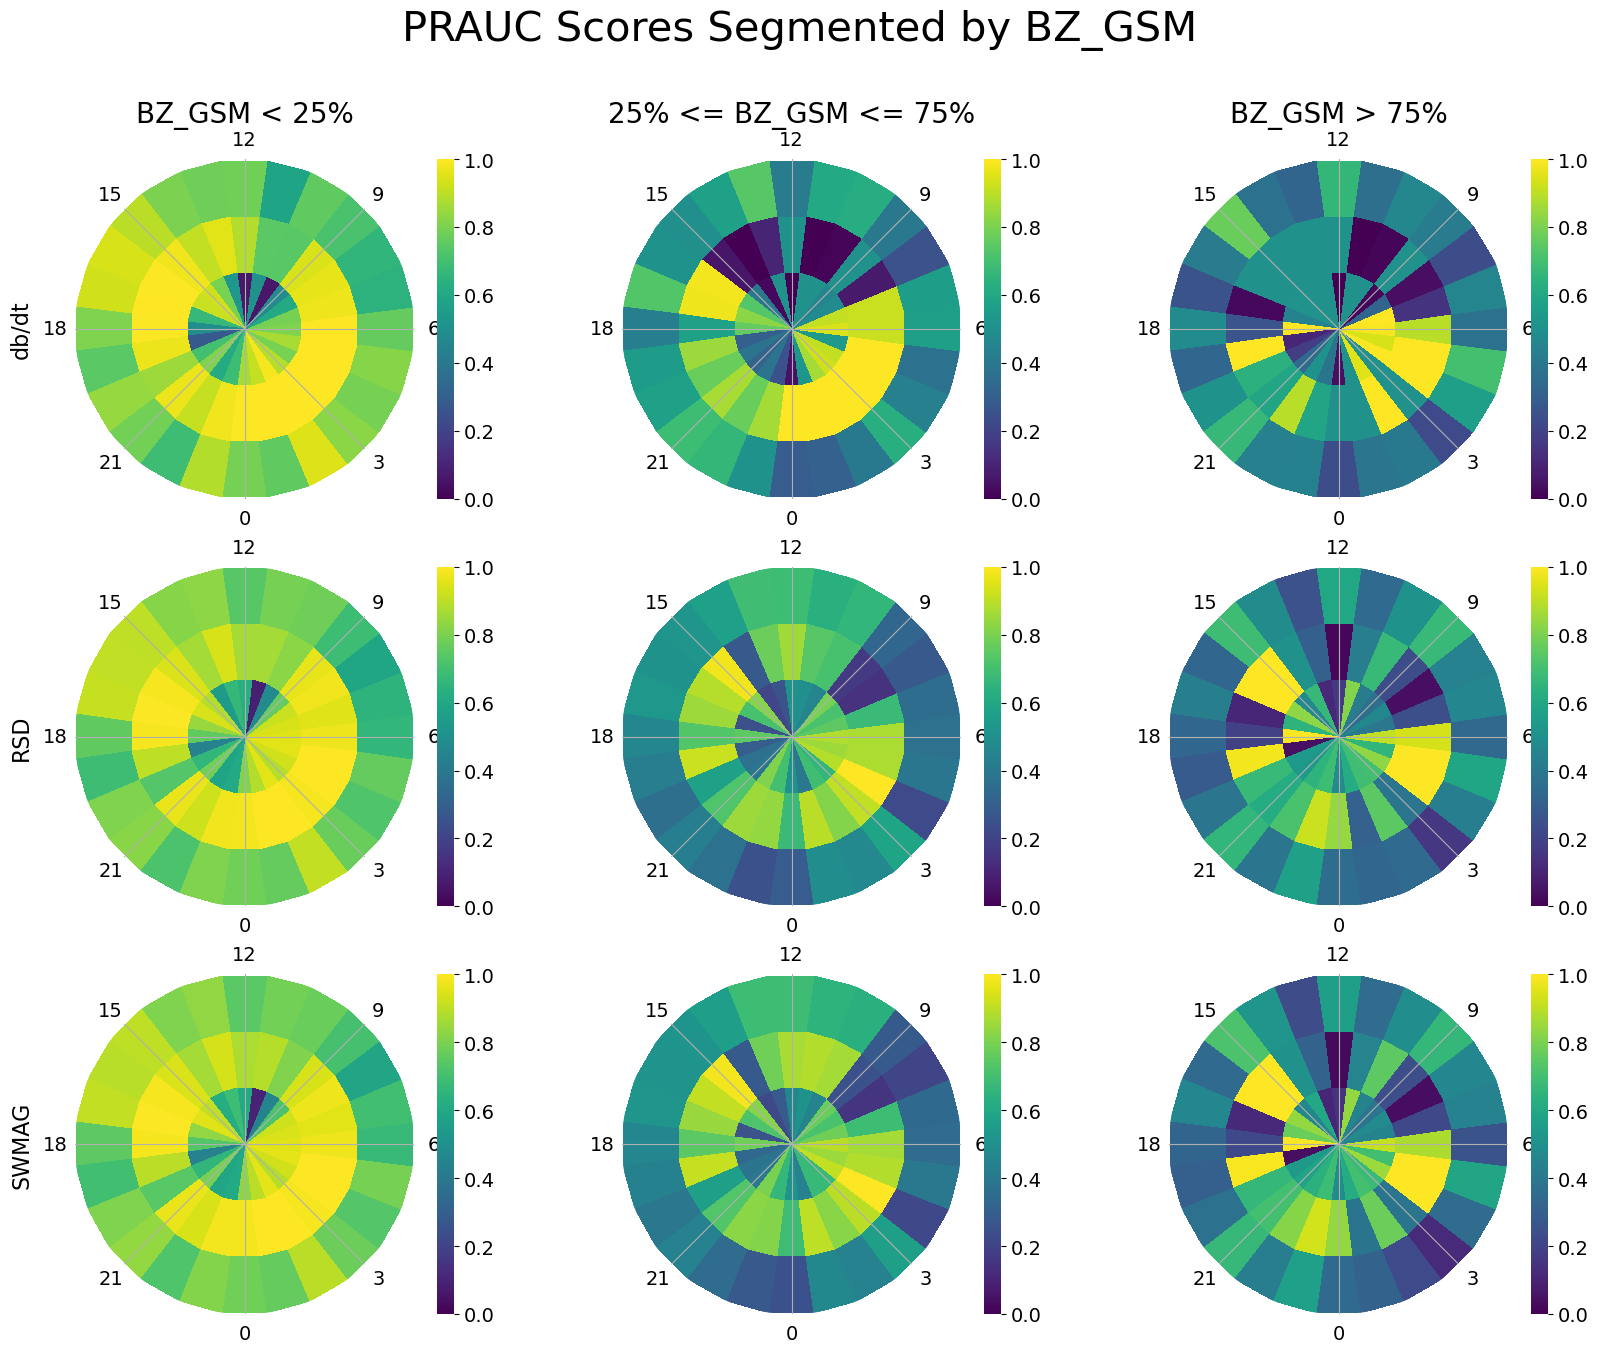

In [139]:
lower_lat_bound = 55
upper_lat_bound = 65
sep_var = 'BZ_GSM'
sep_var_bins = None
metric = 'prauc'

def get_sep_var_and_lat_bins(df, sep_var, sep_var_bins, lower_lat_bound, upper_lat_bound):
	
	if sep_var_bins == None:
		sep_var_bins = [df[sep_var].quantile(0.25), df[sep_var].quantile(0.75)]

	if 'MLAT' not in df.columns:
		raise ValueError('MLAT column not found in the dataframe')
	if sep_var not in df.columns:
		raise ValueError(f'{sep_var} column not found in the dataframe')
	
	var_sep_low_mlat_low = df[(df['MLAT'] < lower_lat_bound) & (df[sep_var] < sep_var_bins[0])]
	var_sep_mid_mlat_low = df[(df['MLAT'] < lower_lat_bound) & (df[sep_var] >= sep_var_bins[0]) & (df[sep_var] <= sep_var_bins[1])]
	var_sep_high_mlat_low = df[(df['MLAT'] < lower_lat_bound) & (df[sep_var] > sep_var_bins[1])]
	var_sep_low_mlat_mid = df[(df['MLAT'] >= lower_lat_bound) & (df['MLAT'] <= upper_lat_bound) & (df[sep_var] < sep_var_bins[0])]
	var_sep_mid_mlat_mid = df[(df['MLAT'] >= lower_lat_bound) & (df['MLAT'] <= upper_lat_bound) & (df[sep_var] >= sep_var_bins[0]) & (df[sep_var] <= sep_var_bins[1])]
	var_sep_high_mlat_mid = df[(df['MLAT'] >= lower_lat_bound) & (df['MLAT'] <= upper_lat_bound) & (df[sep_var] > sep_var_bins[1])]
	var_sep_low_mlat_high = df[(df['MLAT'] > upper_lat_bound) & (df[sep_var] < sep_var_bins[0])]
	var_sep_mid_mlat_high = df[(df['MLAT'] > upper_lat_bound) & (df[sep_var] >= sep_var_bins[0]) & (df[sep_var] <= sep_var_bins[1])]
	var_sep_high_mlat_high = df[(df['MLAT'] > upper_lat_bound) & (df[sep_var] > sep_var_bins[1])]


	final_dict = {'low_mlat_low_sep': var_sep_low_mlat_low, 'low_mlat_mid_sep': var_sep_mid_mlat_low, 'low_mlat_high_sep': var_sep_high_mlat_low,
				  'mid_mlat_low_sep': var_sep_low_mlat_mid, 'mid_mlat_mid_sep': var_sep_mid_mlat_mid, 'mid_mlat_high_sep': var_sep_high_mlat_mid,
				  'high_mlat_low_sep': var_sep_low_mlat_high, 'high_mlat_mid_sep': var_sep_mid_mlat_high, 'high_mlat_high_sep': var_sep_high_mlat_high}
	
	return final_dict


def calculating_individual_mlt_metrics(dict, metric='prauc'):

	results_dict = {'low_sep_var_df': pd.DataFrame(index = range(24), columns = ['low', 'mid', 'high']), 
					'mid_sep_var_df': pd.DataFrame(index = range(24), columns = ['low', 'mid', 'high']), 
					'high_sep_var_df': pd.DataFrame(index = range(24), columns = ['low', 'mid', 'high'])}

	lats = ['low', 'mid', 'high']
	var_seps = ['low', 'mid', 'high']

	# calculating the metrics for the low, mid and high latitudes
	for lat in lats:
		for sep in var_seps:
			for i in range(0, 24):
				temp_df = dict[f'{lat}_mlat_{sep}_sep'][dict[f'{lat}_mlat_{sep}_sep']['MLT'] == i]
				try:
					if metric == 'prauc':
						second_output, first_output, __ = precision_recall_curve(temp_df['actual'], temp_df['predicted_mean'])
						results_dict[f'{sep}_sep_var_df'].loc[i,lat] = auc(first_output, second_output)
					elif metric == 'rocauc':
						first_output, second_output, __ = roc_curve(temp_df['actual'], temp_df['predicted_mean'])
						results_dict[f'{sep}_sep_var_df'].loc[i,lat] = auc(first_output, second_output)
					elif metric == 'ratio':
						results_dict[f'{sep}_sep_var_df'].loc[i,lat] = temp_df['actual'].sum()/len(temp_df)

					else:
						raise ValueError('Metric not recognized')

				except ValueError:
					print(f'No data found for {lat} lat and {sep} sep at {i} MLT')
					print(dict[f'{lat}_mlat_{sep}_sep'])
					raise
					results_dict[f'{sep}_sep_var_df'].loc[i,lat] = np.nan
					
			results_dict[f'{sep}_sep_var_df'] = results_dict[f'{sep}_sep_var_df'].astype(float)

	return results_dict

print(dbht_results_df.columns)
print(dbht_results_df[sep_var].describe())

dbht_dict = get_sep_var_and_lat_bins(dbht_results_df, sep_var, sep_var_bins, lower_lat_bound, upper_lat_bound)
rsd_dict = get_sep_var_and_lat_bins(rsd_results_df, sep_var, sep_var_bins, lower_lat_bound, upper_lat_bound)
swmag_dict = get_sep_var_and_lat_bins(swmag_results_df, sep_var, sep_var_bins, lower_lat_bound, upper_lat_bound)

if sep_var_bins ==None:
	sep_var_bins = ['25%', '75%']

dbht_results = calculating_individual_mlt_metrics(dbht_dict, metric=metric)
rsd_results = calculating_individual_mlt_metrics(rsd_dict, metric=metric)
swmag_results = calculating_individual_mlt_metrics(swmag_dict, metric=metric)

# plotting the results as polar heatmap with MLT=12 at the top of the plot, low mid and high as three different rings
rad = [0,1,2]
theta_ticks = np.linspace(0, 2*np.pi, 8, endpoint=False)
theta_labels = ['0', '3', '6', '9', '12', '15', '18', '21']

# setting global plotting params
mpl.rcParams['axes.linewidth'] = 0
mpl.rcParams['font.size'] = 14
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['xtick.labelsize'] = 14

fig, axes = plt.subplots(3,3, figsize=(20, 15), subplot_kw=dict(projection='polar'))

if metric != 'ratio':
	plotting_norm = mpl.colors.Normalize(vmin=0, vmax=1)
else:
	# plotting_norm = mpl.colors.LogNorm()
	plotting_norm = mpl.colors.Normalize(vmin=0, vmax=1)

# plotting the results segmented by parameter values
plt.suptitle(f'{metric.upper()} Scores Segmented by {sep_var}', fontsize=30)
for i, (results, title) in enumerate(zip([dbht_results, rsd_results, swmag_results], ['db/dt', 'RSD', 'SWMAG'])):
	axes[i,0].set_ylabel(title, labelpad=30)
	for j, (key, value) in enumerate(results.items()):
		if i == 0:
			if j == 0:
				axes[i,j].set_title(f'{sep_var} < {sep_var_bins[0]}')
			elif j == 1:
				axes[i,j].set_title(f'{sep_var_bins[0]} <= {sep_var} <= {sep_var_bins[1]}')
			else:
				axes[i,j].set_title(f'{sep_var} > {sep_var_bins[1]}')
		axes[i,j].set_theta_zero_location('S')
		r,th = np.meshgrid(rad, np.linspace(0, 2*np.pi, 24, endpoint=False))
		cbar = fig.colorbar(axes[i,j].pcolormesh(th, r, value, cmap='viridis', norm=plotting_norm), ax=axes[i,j])
		
		axes[i,j].invert_yaxis()
		axes[i,j].set_xticks(theta_ticks)
		axes[i,j].set_xticklabels(theta_labels)
		axes[i,j].set_yticks([])
plt.show()


Region: GRL-0
SWMAG: 	F1: 0.6166	AUC: 0.6762
TWIN: 	F1: 0.6218	AUC: 0.6796
ALT: 	F1: 0.522	AUC: 0.4726
Region: SVLB
SWMAG: 	F1: 0.5464	AUC: 0.5687
TWIN: 	F1: 0.5357	AUC: 0.5458
ALT: 	F1: 0.439	AUC: 0.4663
Region: CAN-2
SWMAG: 	F1: 0.8857	AUC: 0.9397
TWIN: 	F1: 0.8866	AUC: 0.941
ALT: 	F1: 0.9436	AUC: 0.9646
Region: CEU-1
SWMAG: 	F1: 0.7098	AUC: 0.7991
TWIN: 	F1: 0.7134	AUC: 0.7986
ALT: 	F1: 0.7422	AUC: 0.8355
Region: JPN-0
SWMAG: 	F1: 0.452	AUC: 0.4059
TWIN: 	F1: 0.4515	AUC: 0.4282
ALT: 	F1: nan	AUC: 0.5018


/tmp/ipykernel_653019/3057790746.py:33: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * (prec * rec) / (prec + rec)


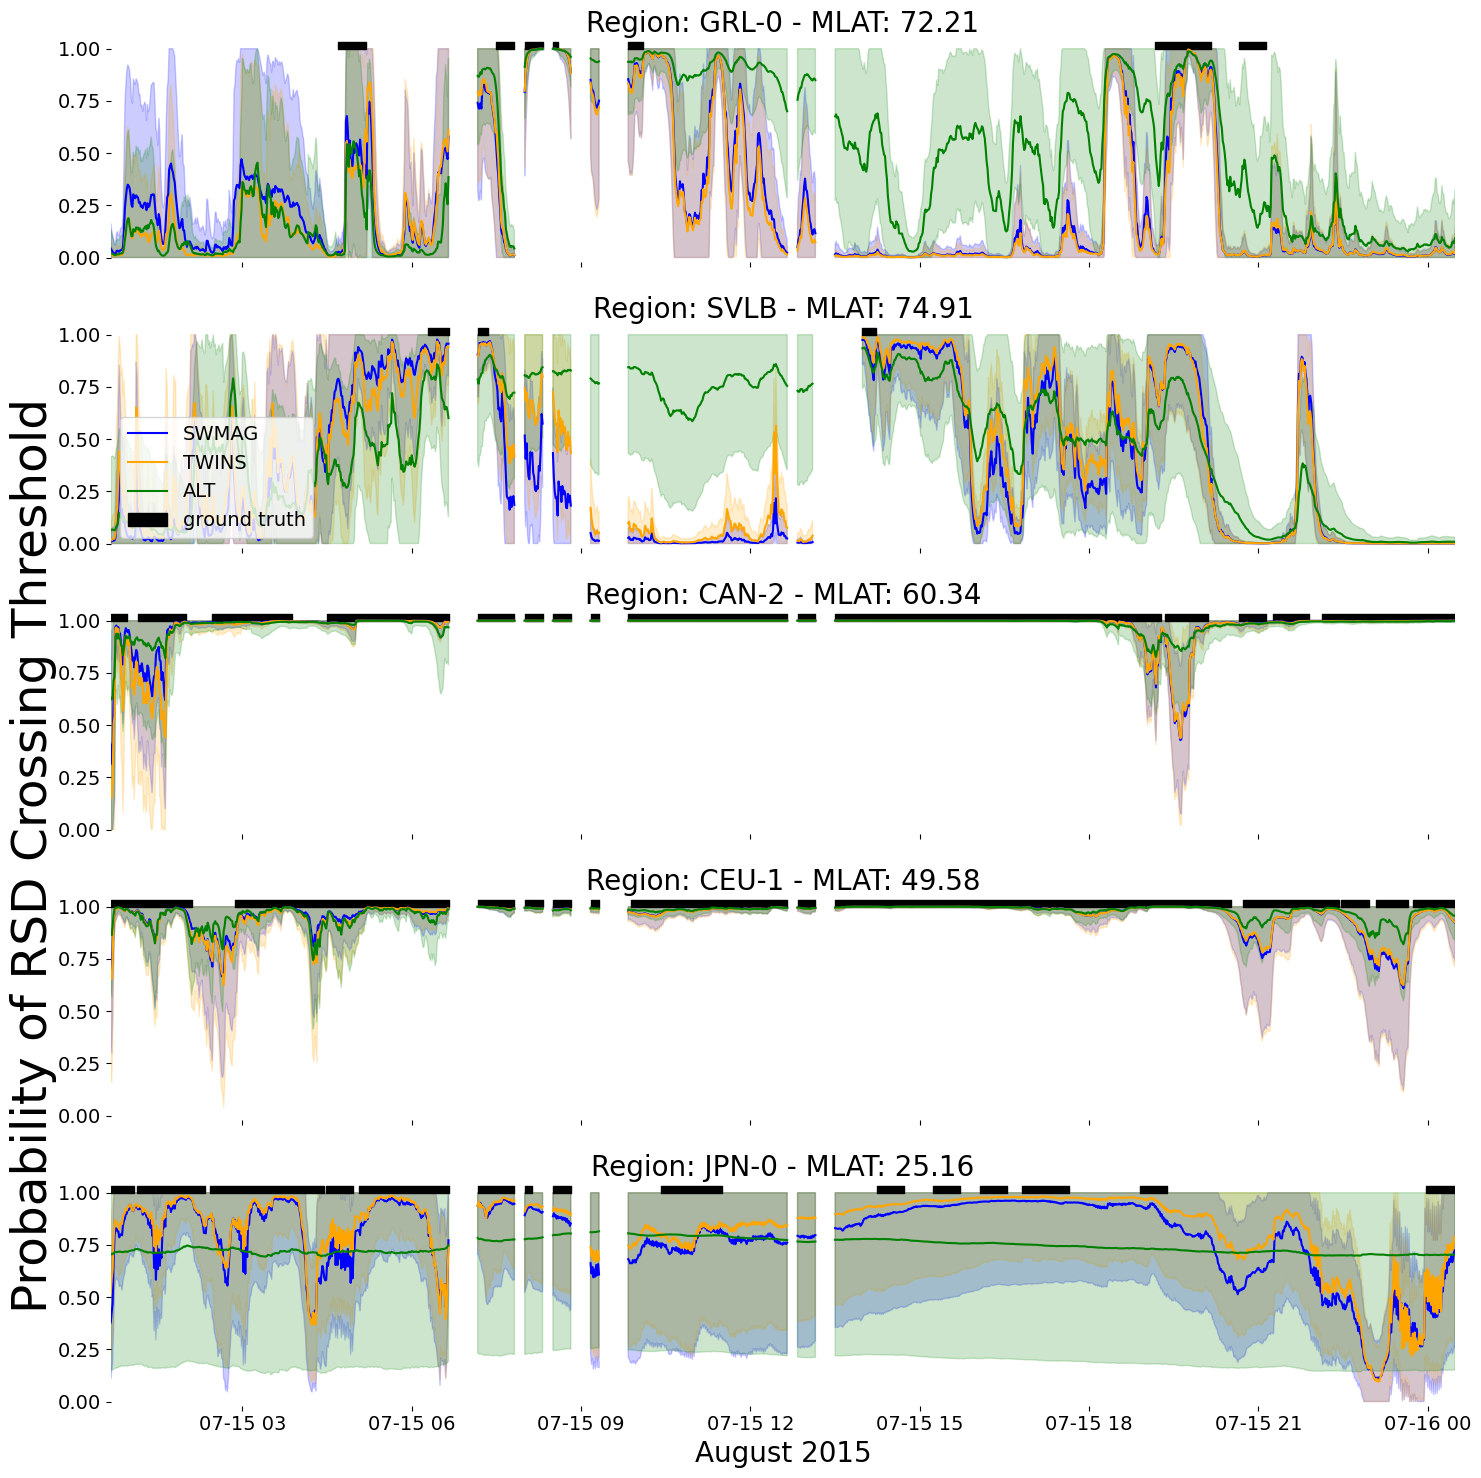

In [ ]:
selected_region = 'FSC-6'

def preparing_results_plotting(region, start_date, end_date):

	list_oversampled = ['JPN-0', 'GRL-1', 'GRL-2', 'SVLB', 'JPN-1']
	if region in list_oversampled:
		swmag_results = pd.read_feather(f'outputs/rsd/non_twins_modeling_region_{region}_version_swmag_v6-oversampling.feather')
		twins_results = pd.read_feather(f'outputs/rsd/twins_modeling_region_{region}_version_twins_v_maxpooling_oversampling.feather')
		alt_results = pd.read_feather(f'outputs/rsd/twins_modeling_region_{region}_version_twins_alt_method_v2_maxpooling_oversampling.feather')
	else:
		swmag_results = pd.read_feather(f'outputs/rsd/non_twins_modeling_region_{region}_version_swmag_v6-1.feather')
		twins_results = pd.read_feather(f'outputs/rsd/twins_modeling_region_{region}_version_twins_v_maxpooling.feather')
		alt_results = pd.read_feather(f'outputs/rsd/twins_modeling_region_{region}_version_twins_alt_method_v2_maxpooling.feather')

	swmag_results.set_index('dates', inplace=True)
	twins_results.set_index('dates', inplace=True)
	alt_results.set_index('dates', inplace=True)

	print(f'Region: {sel_reg}')
	prec, rec, __ = precision_recall_curve(y_true=swmag_results['actual'], probas_pred=swmag_results['predicted_mean'])
	f1 = 2 * (prec * rec) / (prec + rec)
	area = auc(rec, prec)
	# MI = mutual_info_score(swmag_results['actual'], swmag_results['predicted_mean'])
	print(f'SWMAG: \tF1: {round(f1[np.argmax(f1)], 4)}\tAUC: {round(area, 4)}')

	prec, rec, __ = precision_recall_curve(y_true=twins_results['actual'], probas_pred=twins_results['predicted_mean'])
	f1 = 2 * (prec * rec) / (prec + rec)
	area = auc(rec, prec)
	# MI = mutual_info_score(twins_results['actual'], twins_results['predicted_mean'])
	print(f'TWIN: \tF1: {round(f1[np.argmax(f1)], 4)}\tAUC: {round(area, 4)}')

	prec, rec, __ = precision_recall_curve(y_true=alt_results['actual'], probas_pred=alt_results['predicted_mean'])
	f1 = 2 * (prec * rec) / (prec + rec)
	area = auc(rec, prec)
	# MI = mutual_info_score(alt_results['actual'], alt_results['predicted_mean'])
	print(f'ALT: \tF1: {round(f1[np.argmax(f1)], 4)}\tAUC: {round(area, 4)}')

	# start_date = '2012-03-06 00:00:00'
	# end_date = '2012-03-10 12:00:00'

	plotting_range = pd.date_range(start_date, end_date, freq='min')
	plotting_df = pd.DataFrame(index=plotting_range)
	plotting_df = plotting_df.join(swmag_results['actual'], how='left')
	plotting_df = plotting_df.join(swmag_results['predicted_mean'], how='left')
	plotting_df = plotting_df.join(swmag_results['predicted_std'], how='left')
	plotting_df = plotting_df.join(twins_results['predicted_mean'], how='left', rsuffix='_twins')
	plotting_df = plotting_df.join(twins_results['predicted_std'], how='left', rsuffix='_twins')
	plotting_df = plotting_df.join(alt_results['predicted_mean'], how='left', rsuffix='_alt')
	plotting_df = plotting_df.join(alt_results['predicted_std'], how='left', rsuffix='_alt')
	plotting_df['swmag_fill_bottom'] = plotting_df['predicted_mean'] - plotting_df['predicted_std']
	plotting_df['swmag_fill_top'] = plotting_df['predicted_mean'] + plotting_df['predicted_std']
	plotting_df['twins_fill_bottom'] = plotting_df['predicted_mean_twins'] - plotting_df['predicted_std_twins']
	plotting_df['twins_fill_top'] = plotting_df['predicted_mean_twins'] + plotting_df['predicted_std_twins']
	plotting_df['alt_fill_bottom'] = plotting_df['predicted_mean_alt'] - plotting_df['predicted_std_alt']
	plotting_df['alt_fill_top'] = plotting_df['predicted_mean_alt'] + plotting_df['predicted_std_alt']
	plotting_df.clip(lower=0, upper=1, inplace=True)
	plotting_df['bottom'] = plotting_df['actual']*1.00
	plotting_df['top'] = plotting_df['actual']*1.03

	return plotting_df

start_date = '2012-07-10 00:00:00'
end_date = '2012-07-16 12:00:00'
# selected_regions = ['GRL-2', 'FSC-6', 'SVLB', 'CAN-2', 'CEU-1', 'JPN-1']
selected_regions = ['GRL-0', 'SVLB', 'CAN-2', 'CEU-1', 'JPN-0']

fig, axes = plt.subplots(len(selected_regions), 1, figsize=(15, 15), sharex=True)

for i, sel_reg in enumerate(selected_regions):
	plotting_df = preparing_results_plotting(sel_reg, start_date, end_date)
	# creates an array from the y_bar dataframe
	z1=np.array(plotting_df['bottom'])
	# creates another array. These two arrays are compared to create the bar at the top of the plots.
	z2=np.array(plotting_df['top'])

	axes[i].plot(plotting_df.loc[start_date:end_date, 'predicted_mean'], color='blue', label='SWMAG')
	axes[i].fill_between(plotting_df.loc[start_date:end_date].index, plotting_df.loc[start_date:end_date, 'swmag_fill_bottom'], plotting_df.loc[start_date:end_date, 'swmag_fill_top'], color='blue', alpha=0.2)
	axes[i].plot(plotting_df.loc[start_date:end_date, 'predicted_mean_twins'], color='orange', label='TWINS')
	axes[i].fill_between(plotting_df.loc[start_date:end_date].index, plotting_df.loc[start_date:end_date, 'twins_fill_bottom'], plotting_df.loc[start_date:end_date, 'twins_fill_top'], color='orange', alpha=0.2)
	axes[i].plot(plotting_df.loc[start_date:end_date, 'predicted_mean_alt'], color='green', label='ALT')
	axes[i].fill_between(plotting_df.loc[start_date:end_date].index, plotting_df.loc[start_date:end_date, 'alt_fill_bottom'], plotting_df.loc[start_date:end_date, 'alt_fill_top'], color='green', alpha=0.2)
	axes[i].fill_between(plotting_df.index, plotting_df['bottom'], plotting_df['top'], where=z2>z1, alpha=1, label='ground truth', color='black')
	mlat = str(round(results[sel_reg]['mean_lat'], 2))
	axes[i].set_title(f'Region: {sel_reg} - MLAT: {mlat}', fontsize=20)
	plt.margins(x=0, y=0)
	axes[i].set_ylim(-0.02,1.04)

axes[1].legend(loc='lower left')
axes[(len(selected_regions)-1)//2].set_ylabel('Probability of RSD Crossing Threshold', fontsize=35)
axes[(len(selected_regions)-1)//2].yaxis.set_label_coords(-0.04,-0.1)
axes[len(selected_regions)-1].set_xlabel('August 2015', fontsize=20)
plt.subplots_adjust(wspace=1, hspace=1)
plt.tight_layout()

plt.savefig(f'plots/GEM_2024_plots/regions_example.png')


ALT: 	F1: 0.4663	AUC: 0.4815
                     actual  predicted_mean  predicted_std
2011-05-01 00:00:00     NaN             NaN            NaN
2011-05-01 00:01:00     NaN             NaN            NaN
2011-05-01 00:02:00     NaN             NaN            NaN
2011-05-01 00:03:00     NaN             NaN            NaN
2011-05-01 00:04:00     NaN             NaN            NaN
...                     ...             ...            ...
2011-06-01 11:56:00     NaN             NaN            NaN
2011-06-01 11:57:00     NaN             NaN            NaN
2011-06-01 11:58:00     NaN             NaN            NaN
2011-06-01 11:59:00     NaN             NaN            NaN
2011-06-01 12:00:00     NaN             NaN            NaN

[45361 rows x 3 columns]
ALT: 	F1: 0.4469	AUC: 0.3797
                     actual  predicted_mean  predicted_std
2011-05-01 00:00:00     NaN             NaN            NaN
2011-05-01 00:01:00     NaN             NaN            NaN
2011-05-01 00:02:00     NaN    

/tmp/ipykernel_653019/1635609006.py:15: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * (prec * rec) / (prec + rec)


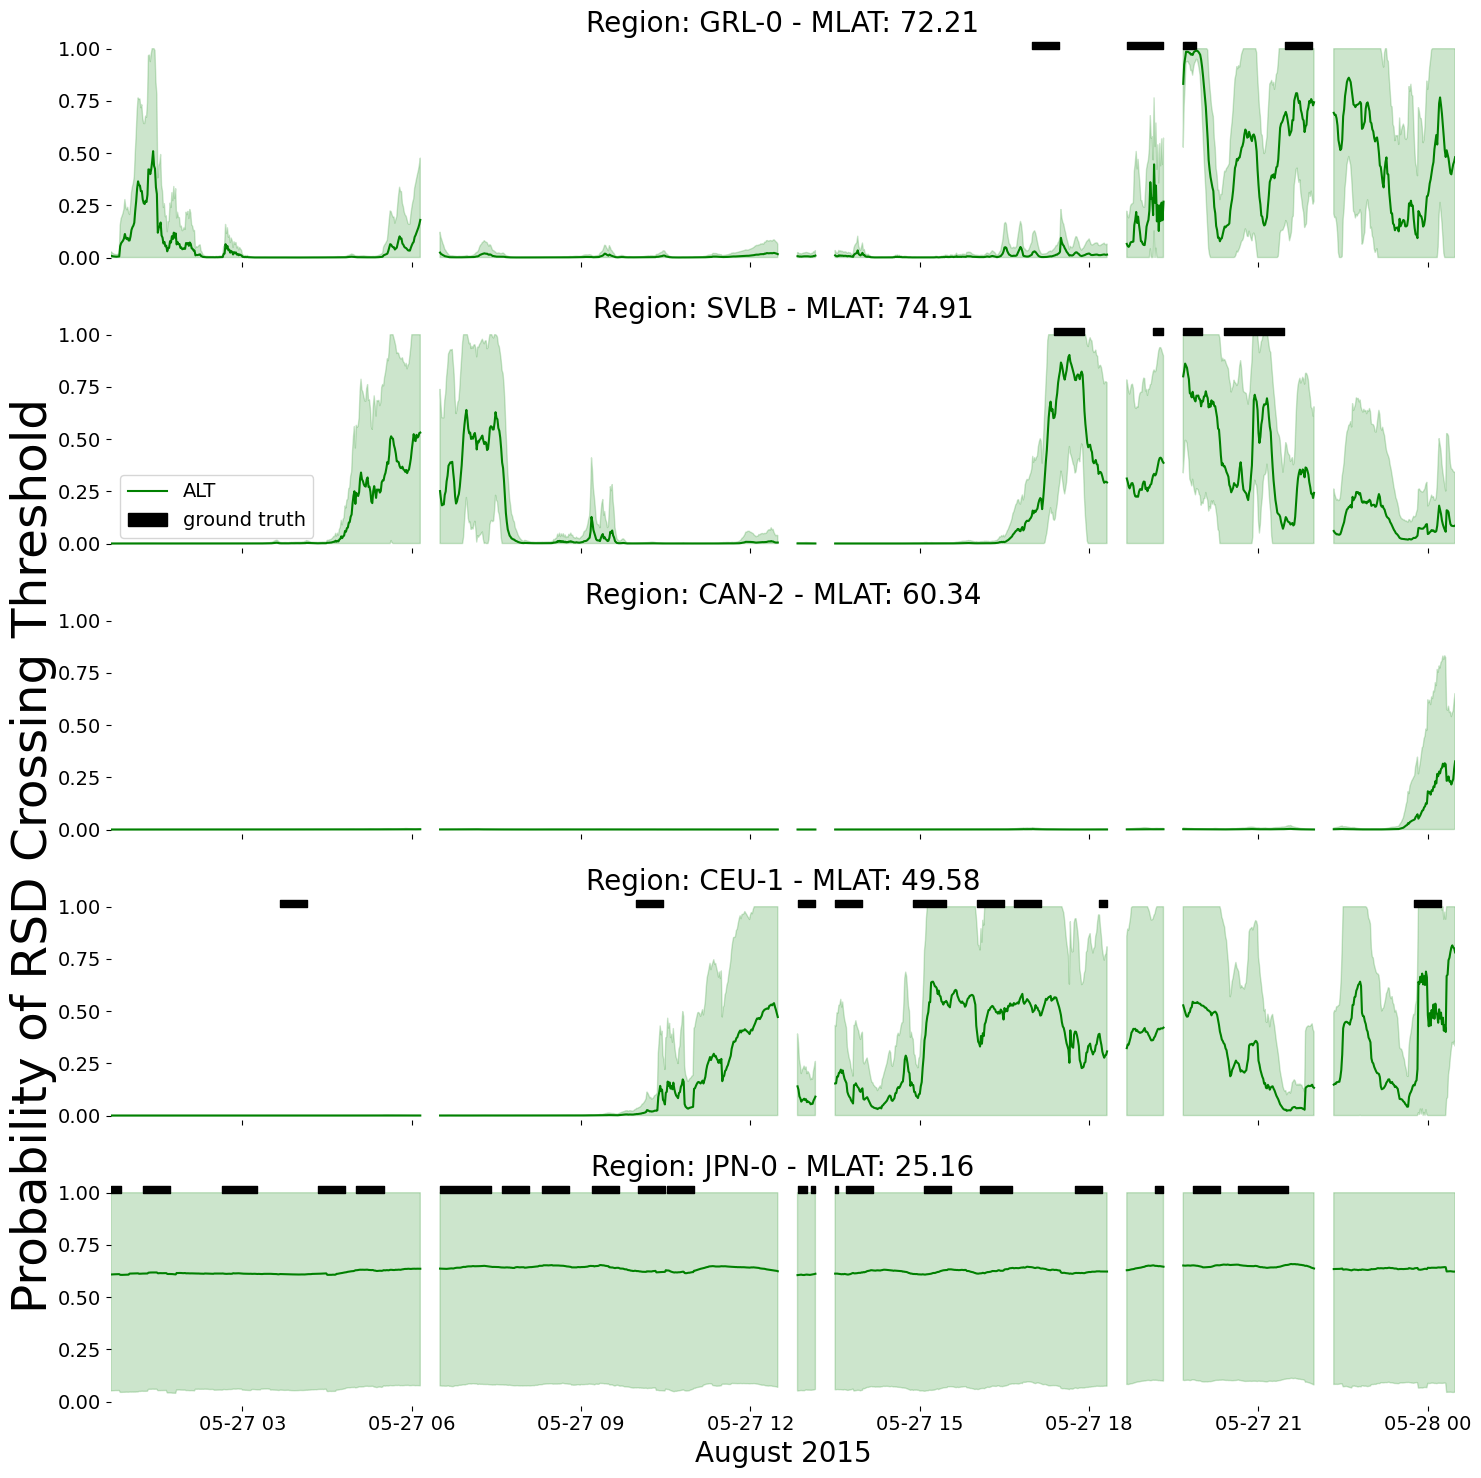

In [ ]:
selected_region = 'FSC-6'

def preparing_dbht_results_plotting(region, start_date, end_date):

	list_oversampled = ['GRL-0', 'GRL-1', 'GRL-2', 'SVLB', 'JPN-1', 'JPN-0']
	if region in list_oversampled:
		
		alt_results = pd.read_feather(f'outputs/dbht_max/twins_modeling_region_{region}_version_twins_v_dbht_maxpooling_oversampling.feather')
	else:
		alt_results = pd.read_feather(f'outputs/dbht_max/twins_modeling_region_{region}_version_twins_v_dbht_maxpooling.feather')

	alt_results.set_index('dates', inplace=True)

	prec, rec, __ = precision_recall_curve(y_true=alt_results['actual'], probas_pred=alt_results['predicted_mean'])
	f1 = 2 * (prec * rec) / (prec + rec)
	area = auc(rec, prec)
	# MI = mutual_info_score(alt_results['actual'], alt_results['predicted_mean'])
	print(f'ALT: \tF1: {round(f1[np.argmax(f1)], 4)}\tAUC: {round(area, 4)}')

	# start_date = '2012-03-06 00:00:00'
	# end_date = '2012-03-10 12:00:00'

	plotting_range = pd.date_range(start_date, end_date, freq='min')
	plotting_df = pd.DataFrame(index=plotting_range)
	plotting_df = plotting_df.join(alt_results['actual'], how='left')
	plotting_df = plotting_df.join(alt_results['predicted_mean'], how='left')
	plotting_df = plotting_df.join(alt_results['predicted_std'], how='left')
	print(plotting_df)
	plotting_df['alt_fill_bottom'] = plotting_df['predicted_mean'] - plotting_df['predicted_std']
	plotting_df['alt_fill_top'] = plotting_df['predicted_mean'] + plotting_df['predicted_std']
	plotting_df.clip(lower=0, upper=1, inplace=True)
	plotting_df['bottom'] = plotting_df['actual']*1.00
	plotting_df['top'] = plotting_df['actual']*1.03

	return plotting_df

start_date = '2011-05-01 00:00:00'
end_date = '2011-06-01 12:00:00'
# selected_regions = ['GRL-2', 'FSC-6', 'SVLB', 'CAN-2', 'CEU-1', 'JPN-1']
selected_regions = ['GRL-0', 'SVLB', 'CAN-2', 'CEU-1', 'JPN-0']

fig, axes = plt.subplots(len(selected_regions), 1, figsize=(15, 15), sharex=True)

for i, sel_reg in enumerate(selected_regions):
	plotting_df = preparing_dbht_results_plotting(sel_reg, start_date, end_date)
	# creates an array from the y_bar dataframe
	z1=np.array(plotting_df['bottom'])
	# creates another array. These two arrays are compared to create the bar at the top of the plots.
	z2=np.array(plotting_df['top'])

	axes[i].plot(plotting_df.loc[start_date:end_date, 'predicted_mean'], color='green', label='ALT')
	axes[i].fill_between(plotting_df.loc[start_date:end_date].index, plotting_df.loc[start_date:end_date, 'alt_fill_bottom'], plotting_df.loc[start_date:end_date, 'alt_fill_top'], color='green', alpha=0.2)
	axes[i].fill_between(plotting_df.index, plotting_df['bottom'], plotting_df['top'], where=z2>z1, alpha=1, label='ground truth', color='black')
	mlat = str(round(results[sel_reg]['mean_lat'], 2))
	axes[i].set_title(f'Region: {sel_reg} - MLAT: {mlat}', fontsize=20)
	plt.margins(x=0, y=0)
	axes[i].set_ylim(-0.02,1.04)

axes[1].legend(loc='lower left')
axes[(len(selected_regions)-1)//2].set_ylabel('Probability of RSD Crossing Threshold', fontsize=35)
axes[(len(selected_regions)-1)//2].yaxis.set_label_coords(-0.04,-0.1)
axes[len(selected_regions)-1].set_xlabel('August 2015', fontsize=20)
plt.subplots_adjust(wspace=1, hspace=1)
plt.tight_layout()

plt.savefig(f'plots/GEM_2024_plots/regions_dbht_example.png')


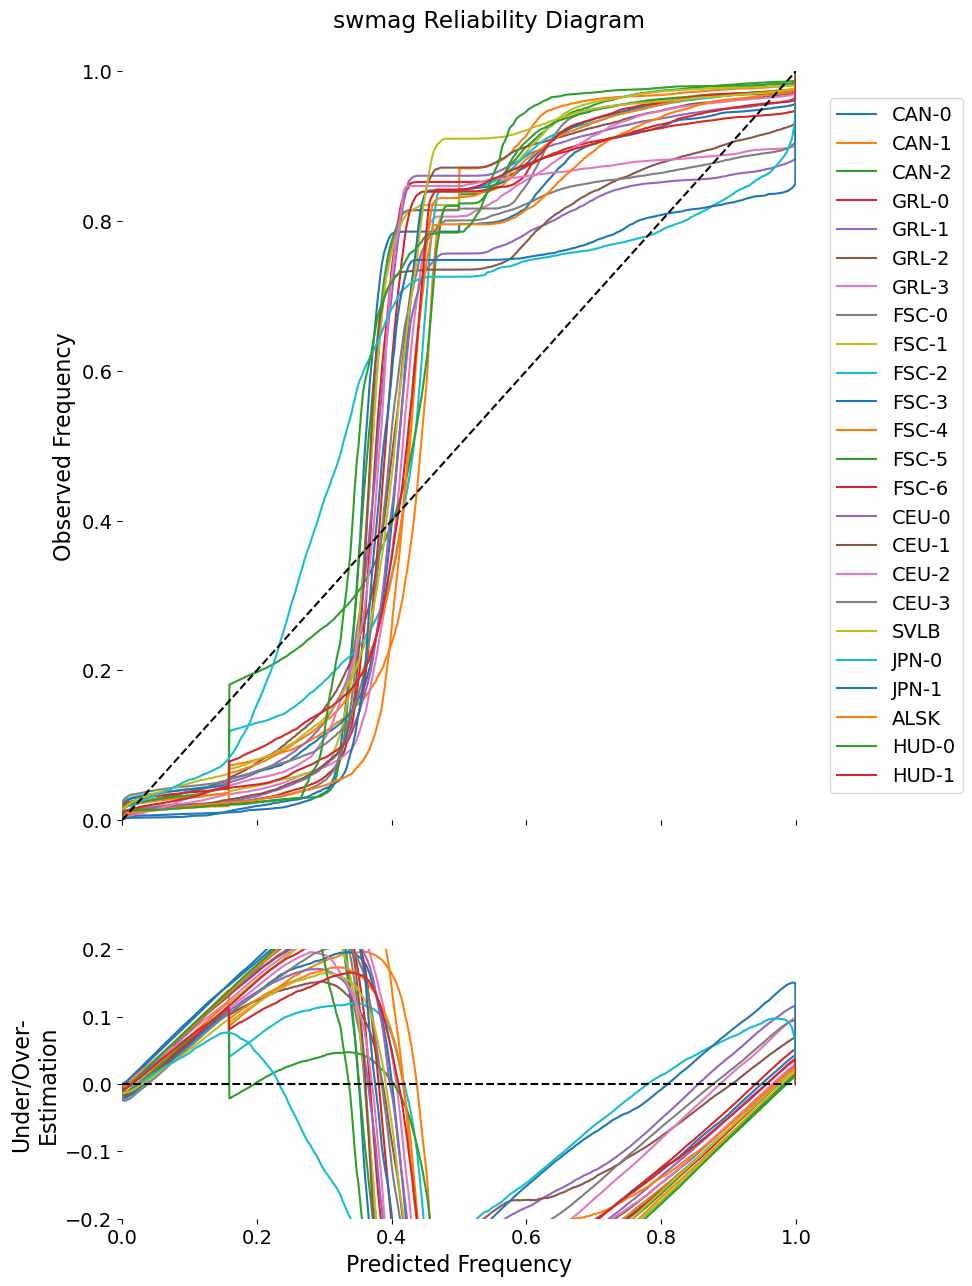

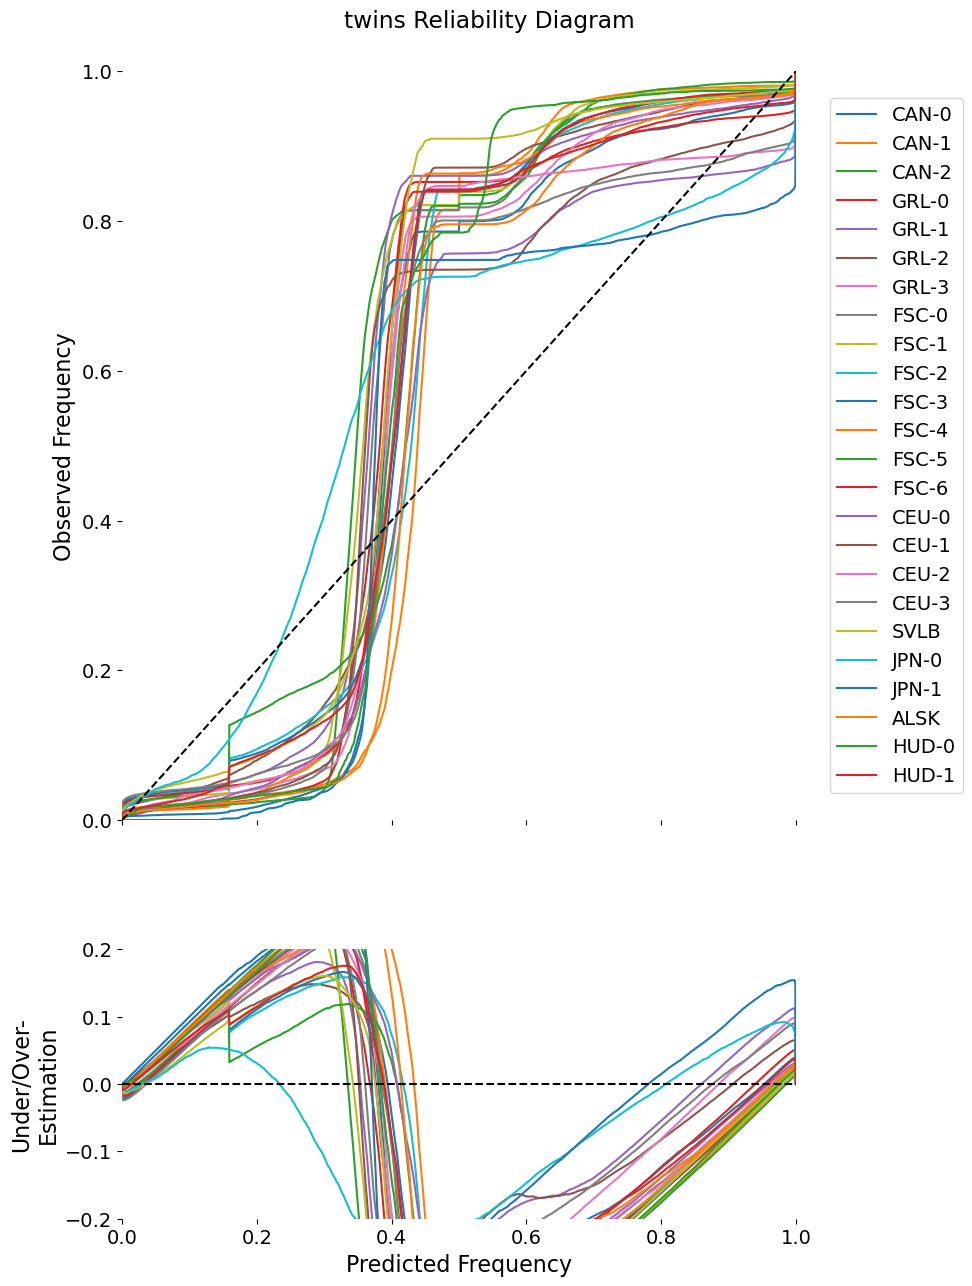

In [ ]:
def plotting_continuious_reliability_diagram(results, model):

	''' Function that plots the reliability diagram for the predictions.'''

	x = np.linspace(0, 1, 1000)

	fig, ax = plt.subplots(ncols=1, nrows=2, sharex=True, figsize=(10,15))

	for region in results.keys():
		predictions = results[region][f'{model}_results'].dropna(inplace=False, subset=['actual', 'predicted_mean', 'predicted_std'])
		actual = predictions['actual']
		predicted_mean = predictions['predicted_mean']
		predicted_std = predictions['predicted_std'].abs()

		standard_error = (actual - predicted_mean)/(np.sqrt(2) * predicted_std).to_numpy() #Standard error for each parameter
		cumulative_dist = np.zeros((len(x), 1)) #Cumulative distribution for each parameter
		for i in standard_error.index:
			cumulative_dist[:,0] += (1/len(standard_error)) * np.heaviside(x - 0.5*(erf(standard_error.loc[i])+1) , 1) #Calculate the cumulative distribution for each parameter

		ax[0].plot(x, cumulative_dist[:,0], label=region)
		ax[1].plot(x, x - cumulative_dist[:,0], label=region)

	#Place legend to the right middle of the figure
	ax[0].legend(bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0.)
	ax[0].plot(x, x, linestyle = '--', color = 'k')
	ax[0].set_ylabel('Observed Frequency')
	ax[0].set_xlim(0,1)
	ax[0].set_ylim(0,1)
	fig.suptitle(f'{model} Reliability Diagram')

	ax[1].plot(x, np.zeros(len(x)), linestyle = '--', color = 'k')
	ax[1].set_ylim(-0.2,0.2)
	ax[1].set_xlabel('Predicted Frequency')
	ax[1].set_ylabel('Under/Over-\nEstimation')
	ax[1].set_aspect('equal')
	plt.subplots_adjust(hspace = -0.20)

	plt.tight_layout()
	plt.savefig(f'plots/{model}_reliability_diagram.png', bbox_inches='tight')

plotting_continuious_reliability_diagram(results, model='swmag')
plotting_continuious_reliability_diagram(results, model='twins')